In [45]:
#load spectres of templates at last point
import os
from astropy.table import Table
import numpy as np
import eazy
import matplotlib.pyplot as plt
from numba import jit
from astropy.io import fits
import helper_module as hmod
from astropy.table import Table, join
import eazy_routines as ez
from astropy import units as u
import time
from astropy.cosmology import Planck18
import pandas as pd
import shutil
import sys, os
import warnings
from scipy.optimize import curve_fit
#warnings.filterwarnings("ignore")

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [46]:
runTime = int(time.time())
__file__ = os.getcwd()+'/'+"gen-template-matrix_byZ.ipynb"
cosmo = Planck18
set2Limit = "EMlines"

In [47]:
############# SETTINGS #############
templCnt = 13
cCap = 0.5
doMultithread = False
threadCnt = 4
trainsetCap = 150
####################################
if not doMultithread: threadCnt = 1

In [48]:

#path = "templates-custom/45k/raw"
path = "templates-custom/EMlines"#!temp
#out_path = "templates-custom/45k"
out_path = "templates-custom"#!temp
path = os.path.dirname(os.path.realpath(__file__)) + "/" + path
out_path = os.path.dirname(os.path.realpath(__file__)) + "/" + out_path

templates_in = [f for f in os.listdir(path) if "bin1.fits" in f or "bin0.fits" in f or ".spec" in f]
spectras = []
for temp in templates_in:
    if ".fits" in temp:
        tab = Table.read(path+"/"+temp)
        flux = tab["flux"].T[-1]
        wave = tab["wave"].T[0]
    elif ".spec" in temp:
        tab = np.loadtxt(path+"/"+temp)
        flux = tab.T[-1]
        wave = tab.T[0]
    spectras.append(flux)
spectras = np.array(spectras)
for i in range(len(spectras)):
    #normalize
    spectras[i] = spectras[i] / np.sum(spectras[i])

In [49]:
############# FILTERS #############
flt = eazy.filters.FilterFile()

filts_nircam = {
        'F090W': 363,
        'F115W': 364,
        'F150W': 365,
        'F182M': 370,
        'F200W': 366,
        'F210M': 371,
        'F277W': 375,
        'F335M': 381,
        'F356W': 376,
        'F410M': 383,
        'F430M': 384,
        'F444W': 358,
        'F460M': 385,
        'F480M': 386
}

filts_HST = {
        'F105W': 202,
        'F125W': 203,
        'F140W': 204,
        'F160W': 205,
        'F435W': 233,
        'F606W': 214,
        'F775W': 216,
        'F814W': 239,
        'F850LP': 240
}

filts = {**filts_nircam, **filts_HST}

mw_reddening = ez.get_atten_dict(filts)

# get zeropoints
zps = [1.0]*len(filts)

In [50]:
############# data loading #############
#load data
inname = "hlsp_jades_jwst_nircam_goods-s-deep_photometry_v1.0_catalog_large_withSpec.fits"
inpath = os.path.join(os.getenv('astrodata'), 'gds/jades/phot', inname)

# print the meta info
with fits.open(inpath) as hdul:
    print(hdul.info())

# load photometry table
tab = Table.read(inpath, hdu=6)
tab_redshifts = Table.read(inpath, hdu=9)

# load fluxes
# CIRC1: 0.10 arcsec aperture (see README)
ext = '_CIRC1'
cols_fluxes = hmod.get_matches(ext, tab.columns, exclude='_ei')
cols_f = np.sort(hmod.get_matches(ext, cols_fluxes, exclude='_e'))
cols_fe = np.sort(hmod.get_matches('_e', cols_fluxes))
cols_fluxes = list(np.vstack([cols_f, cols_fe]).T.flatten())
cols = list(np.insert(cols_fluxes, 0, ['ID', 'RA', 'DEC', 'z_spec','z_spec_quality']))

tab = join(tab, tab_redshifts['ID', 'z_spec', 'z_spec_quality'], join_type='inner', keys='ID')
tab_out = tab[cols]

# convert from nJy to uJy
# and apply MW reddening
keys = np.array(list(mw_reddening.keys()))
for c in cols_fluxes:
    tab_out[c].unit = u.nJy
    tab_out[c] = tab_out[c].to(u.uJy)
    
    # apply MW reddening
    matches = hmod.get_matches(keys, c, get_idxs=True)
    key = keys[np.int32(matches[:,0])][0]
    tab_out[c] *= mw_reddening[key]

# rename columns
for c in cols_f:
    cnew = c.replace(ext, '_flux')
    tab_out.rename_column(c, cnew)

for c in cols_fe:
    cnew = c.replace(ext+'_e', '_err')
    tab_out.rename_column(c, cnew)

# pick out training set
tab_out_Aqual = tab_out[tab_out['z_spec_quality'] == 'A']

#np.random.seed(42)#pick randomly 90% of the A-quality spectra as the training set
tab_out_Aqual_train = tab_out_Aqual[np.random.choice(range(len(tab_out_Aqual)), min(int(len(tab_out_Aqual)*0.9),200), replace=False)]
tab_out_Aqual_test = tab_out_Aqual[~np.isin(tab_out_Aqual['ID'], tab_out_Aqual_train['ID'])]

# save EAZY table
os.makedirs('data', exist_ok=True)
tab_out.write('./data/gds_jades_eazy.fits', format='fits', overwrite=True)
tab_out_Aqual.write('./data/gds_jades_eazy_Aqual.fits', format='fits', overwrite=True)
tab_out_Aqual_train.write('./data/gds_jades_eazy_Aqual_train.fits', format='fits', overwrite=True)
tab_out_Aqual_test.write('./data/gds_jades_eazy_Aqual_test.fits', format='fits', overwrite=True)


Filename: /home/t/astrodata/gds/jades/phot/hlsp_jades_jwst_nircam_goods-s-deep_photometry_v1.0_catalog_large_withSpec.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      13   ()      
  1  FILTERS       1 BinTableHDU     33   23R x 12C   [6A, E, E, E, E, E, E, E, E, E, E, E]   
  2  FLAG          1 BinTableHDU    161   1429R x 75C   [J, D, D, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, I, E, E]   
  3  SIZE          1 BinTableHDU    100   1429R x 43C   [J, D, D, E, D, D, D, D, J, J, J, J, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E]   
  4  CIRC          1 BinTableHDU    856   1429R x 423C   [J, D, D, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E,

In [51]:
#setup intermediate folderstructure and such

def saveTemplateset(templateSpectras):
    #save the new templateset
    for i in range(len(templateSpectras)):
        if f"{i}.spec" in os.listdir(intermediateFolder):
            os.remove(f'{intermediateFolder}/{i}.spec')
            #print("Removed intermediate file: "+f'{intermediateFolder}/{i}.spec')
        flux = templateSpectras[i]
        writeList = np.array([wave, flux]).T
        np.savetxt(f'{intermediateFolder}/{i}.spec', writeList)
        #print("Created template file: "+f'{intermediateFolder}/{i}.spec')
    print("updated template set")

intermediateFolder = "spectras_temp"
if not os.path.exists(intermediateFolder):
    os.makedirs(intermediateFolder)
    print("Created intermediate folder: "+intermediateFolder)
if os.path.exists(f'{intermediateFolder}/paramFile.param'):
    os.remove(f'{intermediateFolder}/paramFile.param')
    print("Removed intermediate file: "+f'{intermediateFolder}/paramFile.param')
with open(f'{intermediateFolder}/paramFile.param', 'w') as p:
    saveTemplateset(spectras[:templCnt])
    for i in range(templCnt):
        p.write(f'{i+1} {intermediateFolder}/{i}.spec\n')
p.close()

Removed intermediate file: spectras_temp/paramFile.param
updated template set


In [52]:
#=== set up paths for eazy

# catalog paths
cat_name = 'gds_jades_eazy_Aqual_train'
cat_path = f'./data/{cat_name}.fits'
keys_id = ['ID id', 'RA ra', 'DEC dec', 'z_spec z_spec']

templ_paths = f'{intermediateFolder}/paramFile.param'

In [53]:
@jit(nopython=True)
def performMatrixOperation(matrix, spectra):
    return np.dot(matrix,spectra)

def runEAZY():
    tpath = f'{intermediateFolder}/paramFile.param'
    with open(tpath) as f:
        lines = f.readlines()
        f.close()
    opath = f'./eazy-output/{runTime}'
    params = {"cat_path": cat_path,
        "templ_path": tpath,
        "out_path": opath,
        "FIX_ZSPEC": 'n',
        "USE_ZSPEC_FOR_REST": 'n',
        "Z_MAX": 15,
        "H0": cosmo.H0,
        "OMEGA_M": cosmo.Om0,
        "OMEGA_L": cosmo.Ode0,
        "CATALOG_FORMAT": 'fits'}
    # write eazy config files
    ___, fnames = ez.write_config(cat_name, filts, zps, keys_id,
        out_path=opath)
    # run eazy
    idx = None
    with HiddenPrints():
        #blockPrint()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            _, __ = ez.run_eazy(params, fnames, n_proc=-1, idx=idx)
            warnings.resetwarnings()
        #enablePrint()
    #zout, hdu = 
    #read the output
    fpath = f'eazy-output/{runTime}/gds_jades_eazy_Aqual_train.zout.fits'
    tbl = Table.read(fpath)
    names = [name for name in tbl.colnames if len(tbl[name].shape) <= 1]
    df = tbl[names].to_pandas()
    #change df 'id' to 'ID'
    df.rename(columns={'id': 'ID'}, inplace=True)

    #merge with catalog zspec
    fpath = './data/gds_jades_eazy_Aqual_train.fits'
    tbl = Table.read(fpath, hdu=1)    
    names = [name for name in tbl.colnames if len(tbl[name].shape) <= 1]
    names = [name for name in names if 
        'ID' in name or
        'EAZY_z_a' in name or 
        'z_spec_source' in name or 
        'z_spec_quality' in name or
        'z_spec_reference' in name
    ]
    df_spec = tbl[names].to_pandas()
    
    # add spec info to the photo table
    df = pd.merge(df, df_spec, on='ID', how='left')

    print("################ EAZY DONE ###################")
    return df

def meassureBadnessOfZ(matrix,spectras):
    #function that encapsulates the whole framework of testing EAZY on a set of spectras
    templateSpectras = performMatrixOperation(matrix,spectras)
    saveTemplateset(templateSpectras)
    Zs = runEAZY()
    z_spec = Zs['z_spec']
    z_phot = Zs['z_phot']
    zDeltas = z_spec - z_phot
    return np.sum(zDeltas**2)

In [54]:
#matrix stuff
#matrix = np.random.uniform(0, 1, (templCnt, spectras.shape[0]))
matrix = np.zeros((templCnt, spectras.shape[0]), dtype=np.float64)
for i in range(templCnt):
    matrix[i][i] = 1
usePrevMatrix = True
if usePrevMatrix:
    matrix = np.loadtxt(f'{out_path}/smartsmartsmartbetter_147.csv', delimiter=',')
    print("Loaded previous matrix")

@jit(nopython=True)
def matrixOp(matrix, spectras):
    vec = np.zeros((templCnt, 1))
    for i in range(templCnt):
        vec[i] = np.sum(matrix[i] * spectras[i])
    return vec


Loaded previous matrix


################### START #######################
initial loss test...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.80it/s]
256it [00:00, 7662.31it/s]
100%|██████████| 198/198 [00:03<00:00, 55.70it/s]


################ EAZY DONE ###################
initial loss test done
loop 0


/tmp/ipykernel_5736/4063478249.py:78: UserWarning: Attempting to set identical bottom == top == 531.6903824657846 results in singular transformations; automatically expanding.
  axs.set_ylim([losses_train[-1], (max(np.array(lossByCFunc)[:,1])-min(np.array(lossByCFunc)[:,1]))*1.1+min(np.array(lossByCFunc)[:,1])])
/tmp/ipykernel_5736/4063478249.py:79: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs.set_xlim([min(np.array(lossByCFunc)[:,0])*1.1, max(np.array(lossByCFunc)[:,0])*1.1])


cMax
test @ cCap: 0.5...
updated template set


100%|██████████| 13/13 [00:08<00:00,  1.46it/s]
256it [00:00, 4445.86it/s]
100%|██████████| 198/198 [00:02<00:00, 76.13it/s]


################ EAZY DONE ###################
first c test done
cMax/2
test @ -cCap: 0.25...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
256it [00:00, 7092.74it/s]
100%|██████████| 198/198 [00:03<00:00, 49.81it/s]


################ EAZY DONE ###################
test at -cCap done
################### loop 0 #######################
poly: [-1211.63649155   902.76855618   531.69038247]
699.8495357495385
trying c: 0.045454545454545456
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
256it [00:00, 5636.20it/s]
100%|██████████| 198/198 [00:03<00:00, 54.33it/s]


################ EAZY DONE ###################
loss: 642.8626694845777, c: 0.045454545454545456
################### loop 1 #######################
poly: [-1208.75727484   830.0683344    564.08157039]
706.5860777253062
trying c: 0.015151515151515152
updated template set


100%|██████████| 13/13 [00:08<00:00,  1.48it/s]
256it [00:00, 6583.74it/s]
100%|██████████| 198/198 [00:03<00:00, 57.86it/s]


################ EAZY DONE ###################
loss: 531.6953347691156, c: 0.015151515151515152
################### loop 2 #######################
poly: [ 17437.61845163 -14434.27025378   3188.62055129    514.66732195]
596.6349869745429
trying c: 0.43939393939393945
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.68it/s]
256it [00:00, 9164.51it/s]
100%|██████████| 198/198 [00:03<00:00, 63.64it/s]


################ EAZY DONE ###################
loss: 681.6673497294885, c: 0.43939393939393945


/tmp/ipykernel_5736/4063478249.py:78: UserWarning: Attempting to set identical bottom == top == 531.6903824657846 results in singular transformations; automatically expanding.
  axs.set_ylim([losses_train[-1], (max(np.array(lossByCFunc)[:,1])-min(np.array(lossByCFunc)[:,1]))*1.1+min(np.array(lossByCFunc)[:,1])])
/tmp/ipykernel_5736/4063478249.py:79: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs.set_xlim([min(np.array(lossByCFunc)[:,0])*1.1, max(np.array(lossByCFunc)[:,0])*1.1])


cMax
test @ cCap: 0.5...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.66it/s]
256it [00:00, 7745.83it/s]
100%|██████████| 198/198 [00:03<00:00, 61.19it/s]


################ EAZY DONE ###################
first c test done
IMPROVEMENT FOUND!!!
$\Delta$ loss: -27.833426229443887


/tmp/ipykernel_5736/4063478249.py:78: UserWarning: Attempting to set identical bottom == top == 503.85695623634075 results in singular transformations; automatically expanding.
  axs.set_ylim([losses_train[-1], (max(np.array(lossByCFunc)[:,1])-min(np.array(lossByCFunc)[:,1]))*1.1+min(np.array(lossByCFunc)[:,1])])
/tmp/ipykernel_5736/4063478249.py:79: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs.set_xlim([min(np.array(lossByCFunc)[:,0])*1.1, max(np.array(lossByCFunc)[:,0])*1.1])


cMax
test @ cCap: 0.5...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.67it/s]
256it [00:00, 7612.17it/s]
100%|██████████| 198/198 [00:03<00:00, 55.51it/s]


################ EAZY DONE ###################
first c test done
cMax/2
test @ -cCap: 0.25...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
256it [00:00, 7206.32it/s]
100%|██████████| 198/198 [00:03<00:00, 58.79it/s]


################ EAZY DONE ###################
test at -cCap done
################### loop 0 #######################
poly: [-1397.98584226  1055.98147491   503.85695624]
703.268288175415
trying c: 0.12121212121212122
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.65it/s]
256it [00:00, 7712.94it/s]
100%|██████████| 198/198 [00:03<00:00, 61.22it/s]


################ EAZY DONE ###################
loss: 680.3912918694022, c: 0.12121212121212122
################### loop 1 #######################
poly: [-1787.58293148  1209.10115471   519.64440503]
724.100038466066
trying c: 0.05050505050505051
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
256it [00:00, 8108.91it/s]
100%|██████████| 198/198 [00:03<00:00, 55.73it/s]


################ EAZY DONE ###################
loss: 631.7258234739221, c: 0.05050505050505051
################### loop 2 #######################
poly: [ 13457.91952716 -11398.3035456    2680.37692299    509.70913246]
619.4136220377948
trying c: 0.3080808080808081
updated template set


100%|██████████| 13/13 [00:08<00:00,  1.61it/s]
256it [00:00, 7673.86it/s]
100%|██████████| 198/198 [00:03<00:00, 54.88it/s]


################ EAZY DONE ###################
loss: 680.4772319907108, c: 0.3080808080808081


/tmp/ipykernel_5736/4063478249.py:78: UserWarning: Attempting to set identical bottom == top == 503.85695623634075 results in singular transformations; automatically expanding.
  axs.set_ylim([losses_train[-1], (max(np.array(lossByCFunc)[:,1])-min(np.array(lossByCFunc)[:,1]))*1.1+min(np.array(lossByCFunc)[:,1])])
/tmp/ipykernel_5736/4063478249.py:79: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs.set_xlim([min(np.array(lossByCFunc)[:,0])*1.1, max(np.array(lossByCFunc)[:,0])*1.1])


cMax
test @ cCap: 0.5...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.67it/s]
256it [00:00, 8052.42it/s]
100%|██████████| 198/198 [00:03<00:00, 59.14it/s]


################ EAZY DONE ###################
first c test done
cMax/2
test @ -cCap: 0.25...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.67it/s]
256it [00:00, 7852.89it/s]
100%|██████████| 198/198 [00:03<00:00, 56.13it/s]


################ EAZY DONE ###################
test at -cCap done
################### loop 0 #######################
poly: [-222.41800544  166.81678118  503.85695624]
535.1357171751312
trying c: 0.05555555555555556
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
256it [00:00, 7115.07it/s]
100%|██████████| 198/198 [00:03<00:00, 58.07it/s]


################ EAZY DONE ###################
loss: 531.6575044006345, c: 0.05555555555555556
################### loop 1 #######################
poly: [-239.76366992  157.27666571  511.95159966]
537.7436114222455
trying c: 0.05555555555555556
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
256it [00:00, 6633.69it/s]
100%|██████████| 198/198 [00:03<00:00, 57.97it/s]


################ EAZY DONE ###################
loss: 531.6575044006345, c: 0.05555555555555556
################### loop 2 #######################
poly: [ 4003.13156752 -3224.76668108   667.20822712   503.85695624]
510.9653717167021
trying c: 0.30303030303030304
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.67it/s]
256it [00:00, 7601.28it/s]
100%|██████████| 198/198 [00:03<00:00, 60.70it/s]


################ EAZY DONE ###################
loss: 531.6601049745263, c: 0.30303030303030304


/tmp/ipykernel_5736/4063478249.py:78: UserWarning: Attempting to set identical bottom == top == 503.85695623634075 results in singular transformations; automatically expanding.
  axs.set_ylim([losses_train[-1], (max(np.array(lossByCFunc)[:,1])-min(np.array(lossByCFunc)[:,1]))*1.1+min(np.array(lossByCFunc)[:,1])])
/tmp/ipykernel_5736/4063478249.py:79: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs.set_xlim([min(np.array(lossByCFunc)[:,0])*1.1, max(np.array(lossByCFunc)[:,0])*1.1])


cMax
test @ cCap: 0.5...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.67it/s]
256it [00:00, 7289.98it/s]
100%|██████████| 198/198 [00:03<00:00, 59.90it/s]


################ EAZY DONE ###################
first c test done
cMax/2
test @ -cCap: 0.25...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.68it/s]
256it [00:00, 8007.02it/s]
100%|██████████| 198/198 [00:03<00:00, 57.19it/s]


################ EAZY DONE ###################
test at -cCap done
################### loop 0 #######################
poly: [-223.7459064   167.80872126  503.85695624]
535.3209586205193
trying c: 0.10101010101010102
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
256it [00:00, 6878.60it/s]
100%|██████████| 198/198 [00:03<00:00, 54.78it/s]


################ EAZY DONE ###################
loss: 531.617054482637, c: 0.10101010101010102
################### loop 1 #######################
poly: [-282.83560532  187.93270241  507.61578753]
538.8341878756056
trying c: 0.020202020202020204
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.67it/s]
256it [00:00, 7291.22it/s]
100%|██████████| 198/198 [00:03<00:00, 60.15it/s]


################ EAZY DONE ###################
loss: 531.6584391343924, c: 0.020202020202020204
################### loop 2 #######################
poly: [ 2360.72473546 -1909.95897666   404.0352737    512.29631551]
519.3800620705399
trying c: 0.2575757575757576
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
256it [00:00, 6423.48it/s]
100%|██████████| 198/198 [00:03<00:00, 60.80it/s]


################ EAZY DONE ###################
loss: 531.82500752308, c: 0.2575757575757576


/tmp/ipykernel_5736/4063478249.py:78: UserWarning: Attempting to set identical bottom == top == 503.85695623634075 results in singular transformations; automatically expanding.
  axs.set_ylim([losses_train[-1], (max(np.array(lossByCFunc)[:,1])-min(np.array(lossByCFunc)[:,1]))*1.1+min(np.array(lossByCFunc)[:,1])])
/tmp/ipykernel_5736/4063478249.py:79: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs.set_xlim([min(np.array(lossByCFunc)[:,0])*1.1, max(np.array(lossByCFunc)[:,0])*1.1])


cMax
test @ cCap: 0.5...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.67it/s]
256it [00:00, 6752.88it/s]
100%|██████████| 198/198 [00:03<00:00, 59.57it/s]


################ EAZY DONE ###################
first c test done
cMax/2
test @ -cCap: 0.25...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
256it [00:00, 6844.13it/s]
100%|██████████| 198/198 [00:03<00:00, 60.35it/s]


################ EAZY DONE ###################
test at -cCap done
################### loop 0 #######################
poly: [-223.77625895  167.92543219  503.85695624]
535.3604666056503
trying c: 0.10101010101010102
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
256it [00:00, 6455.18it/s]
100%|██████████| 198/198 [00:03<00:00, 57.28it/s]


################ EAZY DONE ###################
loss: 531.6306908110798, c: 0.10101010101010102
################### loop 1 #######################
poly: [-282.87569301  188.05272881  507.61640681]
538.8702664391875
trying c: 0.030303030303030304
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
256it [00:00, 6950.64it/s]
100%|██████████| 198/198 [00:03<00:00, 58.26it/s]


################ EAZY DONE ###################
loss: 531.6851130119569, c: 0.030303030303030304
################### loop 2 #######################
poly: [ 2706.9427581  -2189.87888543   462.90292269   509.6201543 ]
517.6194988795398
trying c: 0.3434343434343435
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.68it/s]
256it [00:00, 8122.53it/s]
100%|██████████| 198/198 [00:03<00:00, 60.72it/s]


################ EAZY DONE ###################
loss: 531.8577198680371, c: 0.3434343434343435


/tmp/ipykernel_5736/4063478249.py:78: UserWarning: Attempting to set identical bottom == top == 503.85695623634075 results in singular transformations; automatically expanding.
  axs.set_ylim([losses_train[-1], (max(np.array(lossByCFunc)[:,1])-min(np.array(lossByCFunc)[:,1]))*1.1+min(np.array(lossByCFunc)[:,1])])
/tmp/ipykernel_5736/4063478249.py:79: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs.set_xlim([min(np.array(lossByCFunc)[:,0])*1.1, max(np.array(lossByCFunc)[:,0])*1.1])


cMax
test @ cCap: 0.5...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.66it/s]
256it [00:00, 7683.52it/s]
100%|██████████| 198/198 [00:03<00:00, 58.57it/s]


################ EAZY DONE ###################
first c test done
cMax/2
test @ -cCap: 0.25...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
256it [00:00, 6729.31it/s]
100%|██████████| 198/198 [00:03<00:00, 59.32it/s]


################ EAZY DONE ###################
test at -cCap done
################### loop 0 #######################
poly: [-223.87136293  168.10409335  503.85695624]
535.414125754907
trying c: 0.07575757575757576
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
256it [00:00, 8924.27it/s]
100%|██████████| 198/198 [00:03<00:00, 54.87it/s]


################ EAZY DONE ###################
loss: 531.7260162607793, c: 0.07575757575757576
################### loop 1 #######################
poly: [-267.72998751  175.95189293  509.83093133]
538.7397854609042
trying c: 0.005050505050505051
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
256it [00:00, 6971.40it/s]
100%|██████████| 198/198 [00:03<00:00, 57.88it/s]


################ EAZY DONE ###################
loss: 531.6921001057146, c: 0.005050505050505051
################### loop 2 #######################
poly: [ 1906.4057289  -1550.30198359   329.85836601   516.30944936]
522.2069201699207
trying c: 0.0
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
256it [00:00, 7538.79it/s]
100%|██████████| 198/198 [00:03<00:00, 60.38it/s]


################ EAZY DONE ###################
loss: 531.6903824657846, c: 0.0


/tmp/ipykernel_5736/4063478249.py:78: UserWarning: Attempting to set identical bottom == top == 503.85695623634075 results in singular transformations; automatically expanding.
  axs.set_ylim([losses_train[-1], (max(np.array(lossByCFunc)[:,1])-min(np.array(lossByCFunc)[:,1]))*1.1+min(np.array(lossByCFunc)[:,1])])
/tmp/ipykernel_5736/4063478249.py:79: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs.set_xlim([min(np.array(lossByCFunc)[:,0])*1.1, max(np.array(lossByCFunc)[:,0])*1.1])


cMax
test @ cCap: 0.5...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
256it [00:00, 5810.10it/s]
100%|██████████| 198/198 [00:03<00:00, 57.15it/s]


################ EAZY DONE ###################
first c test done
cMax/2
test @ -cCap: 0.25...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
256it [00:00, 8409.37it/s]
100%|██████████| 198/198 [00:03<00:00, 55.33it/s]


################ EAZY DONE ###################
test at -cCap done
################### loop 0 #######################
poly: [-1639.7467852   1139.43597967   503.85695624]
701.8012918312061
trying c: 0.15151515151515152
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.65it/s]
256it [00:00, 9182.30it/s]
100%|██████████| 198/198 [00:03<00:00, 56.92it/s]


################ EAZY DONE ###################
loss: 705.7486667755917, c: 0.15151515151515152
################### loop 1 #######################
poly: [-2095.09424699  1337.88408802   514.04164288]
727.6279571412003
trying c: 0.06060606060606061
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
256it [00:00, 7839.71it/s]
100%|██████████| 198/198 [00:03<00:00, 55.10it/s]


################ EAZY DONE ###################
loss: 643.029277739272, c: 0.06060606060606061
################### loop 2 #######################
poly: [ 14011.35457588 -12099.94330514   2862.9469422     505.85085724]
611.3328668599613
trying c: 0.0
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.67it/s]
256it [00:00, 8673.13it/s]
100%|██████████| 198/198 [00:03<00:00, 57.27it/s]


################ EAZY DONE ###################
loss: 531.6903824657846, c: 0.0


/tmp/ipykernel_5736/4063478249.py:78: UserWarning: Attempting to set identical bottom == top == 503.85695623634075 results in singular transformations; automatically expanding.
  axs.set_ylim([losses_train[-1], (max(np.array(lossByCFunc)[:,1])-min(np.array(lossByCFunc)[:,1]))*1.1+min(np.array(lossByCFunc)[:,1])])
/tmp/ipykernel_5736/4063478249.py:79: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs.set_xlim([min(np.array(lossByCFunc)[:,0])*1.1, max(np.array(lossByCFunc)[:,0])*1.1])


cMax
test @ cCap: 0.5...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.67it/s]
256it [00:00, 8512.37it/s]
100%|██████████| 198/198 [00:03<00:00, 58.25it/s]


################ EAZY DONE ###################
first c test done
cMax/2
test @ -cCap: 0.25...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
256it [00:00, 6618.84it/s]
100%|██████████| 198/198 [00:03<00:00, 51.76it/s]


################ EAZY DONE ###################
test at -cCap done
################### loop 0 #######################
poly: [-1411.39966707  1058.65140121   503.85695624]
702.3731553383614
trying c: 0.005050505050505051
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
256it [00:00, 6720.21it/s]
100%|██████████| 198/198 [00:03<00:00, 59.56it/s]


################ EAZY DONE ###################
loss: 531.6919184422561, c: 0.005050505050505051
################### loop 1 #######################
poly: [-1329.76231552   995.1091461    515.10398035]
701.2730049003419
trying c: 0.020202020202020204
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.68it/s]
256it [00:00, 7422.67it/s]
100%|██████████| 198/198 [00:03<00:00, 55.26it/s]


################ EAZY DONE ###################
loss: 531.6718944794186, c: 0.020202020202020204
################### loop 2 #######################
poly: [ 1033.48600085 -2111.24044248  1131.53330743   513.19445869]
566.950349860604
trying c: 0.0
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.66it/s]
256it [00:00, 6976.15it/s]
100%|██████████| 198/198 [00:03<00:00, 57.11it/s]


################ EAZY DONE ###################
loss: 531.6903824657846, c: 0.0


/tmp/ipykernel_5736/4063478249.py:78: UserWarning: Attempting to set identical bottom == top == 503.85695623634075 results in singular transformations; automatically expanding.
  axs.set_ylim([losses_train[-1], (max(np.array(lossByCFunc)[:,1])-min(np.array(lossByCFunc)[:,1]))*1.1+min(np.array(lossByCFunc)[:,1])])
/tmp/ipykernel_5736/4063478249.py:79: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs.set_xlim([min(np.array(lossByCFunc)[:,0])*1.1, max(np.array(lossByCFunc)[:,0])*1.1])


cMax
test @ cCap: 0.2013195515266416...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
256it [00:00, 7977.40it/s]
100%|██████████| 198/198 [00:03<00:00, 60.53it/s]


################ EAZY DONE ###################
first c test done
IMPROVEMENT FOUND!!!
$\Delta$ loss: -18.24478164077476


/tmp/ipykernel_5736/4063478249.py:78: UserWarning: Attempting to set identical bottom == top == 485.612174595566 results in singular transformations; automatically expanding.
  axs.set_ylim([losses_train[-1], (max(np.array(lossByCFunc)[:,1])-min(np.array(lossByCFunc)[:,1]))*1.1+min(np.array(lossByCFunc)[:,1])])
/tmp/ipykernel_5736/4063478249.py:79: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs.set_xlim([min(np.array(lossByCFunc)[:,0])*1.1, max(np.array(lossByCFunc)[:,0])*1.1])


cMax
test @ cCap: 0.5...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
256it [00:00, 6420.02it/s]
100%|██████████| 198/198 [00:03<00:00, 61.66it/s]


################ EAZY DONE ###################
first c test done
cMax/2
test @ -cCap: 0.25...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
256it [00:00, 7654.28it/s]
100%|██████████| 198/198 [00:03<00:00, 59.30it/s]


################ EAZY DONE ###################
test at -cCap done
################### loop 0 #######################
poly: [-1139.65175608   854.73620686   485.6121746 ]
645.874723971932
trying c: 0.04040404040404041
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
256it [00:00, 6585.43it/s]
100%|██████████| 198/198 [00:03<00:00, 51.37it/s]


################ EAZY DONE ###################
loss: 623.3477070259265, c: 0.04040404040404041
################### loop 1 #######################
poly: [-1085.50628394   723.22371855   533.61226275]
654.0750723169792
trying c: 0.0
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
256it [00:00, 8280.51it/s]
100%|██████████| 198/198 [00:03<00:00, 58.62it/s]


################ EAZY DONE ###################
loss: 531.6903824657846, c: 0.0
################### loop 2 #######################
poly: [ 22431.71154753 -17779.12258525   3520.46552669    508.65127853]
507.6930000132548
trying c: 0.4090909090909091
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
256it [00:00, 6395.36it/s]
100%|██████████| 198/198 [00:03<00:00, 55.71it/s]


################ EAZY DONE ###################
loss: 628.0666883188669, c: 0.4090909090909091


/tmp/ipykernel_5736/4063478249.py:78: UserWarning: Attempting to set identical bottom == top == 485.612174595566 results in singular transformations; automatically expanding.
  axs.set_ylim([losses_train[-1], (max(np.array(lossByCFunc)[:,1])-min(np.array(lossByCFunc)[:,1]))*1.1+min(np.array(lossByCFunc)[:,1])])
/tmp/ipykernel_5736/4063478249.py:79: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs.set_xlim([min(np.array(lossByCFunc)[:,0])*1.1, max(np.array(lossByCFunc)[:,0])*1.1])


cMax
test @ cCap: 0.5...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.66it/s]
256it [00:00, 6925.53it/s]
100%|██████████| 198/198 [00:03<00:00, 58.60it/s]


################ EAZY DONE ###################
first c test done
cMax/2
test @ -cCap: 0.25...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.68it/s]
256it [00:00, 6967.19it/s]
100%|██████████| 198/198 [00:03<00:00, 58.19it/s]


################ EAZY DONE ###################
test at -cCap done
################### loop 0 #######################
poly: [-368.14845197  276.36797953  485.6121746 ]
537.4793355885248
trying c: 0.14141414141414144
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
256it [00:00, 7985.29it/s]
100%|██████████| 198/198 [00:03<00:00, 59.52it/s]


################ EAZY DONE ###################
loss: 531.6959392836629, c: 0.14141414141414144
################### loop 1 #######################
poly: [-461.22549209  315.85867035  488.13942649]
542.2163917467713
trying c: 0.12121212121212122
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
256it [00:00, 7186.21it/s]
100%|██████████| 198/198 [00:03<00:00, 54.72it/s]


################ EAZY DONE ###################
loss: 531.6957803614225, c: 0.12121212121212122
################### loop 2 #######################
poly: [ 2859.13829706 -2509.32664978   632.05744568   485.67801238]
519.991120251716
trying c: 0.3535353535353536
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.68it/s]
256it [00:00, 7300.19it/s]
100%|██████████| 198/198 [00:03<00:00, 59.82it/s]


################ EAZY DONE ###################
loss: 531.6897325315748, c: 0.3535353535353536


/tmp/ipykernel_5736/4063478249.py:78: UserWarning: Attempting to set identical bottom == top == 485.612174595566 results in singular transformations; automatically expanding.
  axs.set_ylim([losses_train[-1], (max(np.array(lossByCFunc)[:,1])-min(np.array(lossByCFunc)[:,1]))*1.1+min(np.array(lossByCFunc)[:,1])])
/tmp/ipykernel_5736/4063478249.py:79: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs.set_xlim([min(np.array(lossByCFunc)[:,0])*1.1, max(np.array(lossByCFunc)[:,0])*1.1])


cMax
test @ cCap: 0.5...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.73it/s]
256it [00:00, 6350.80it/s]
100%|██████████| 198/198 [00:03<00:00, 60.94it/s]


################ EAZY DONE ###################
first c test done
cMax/2
test @ -cCap: 0.25...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
256it [00:00, 7028.99it/s]
100%|██████████| 198/198 [00:03<00:00, 57.84it/s]


################ EAZY DONE ###################
test at -cCap done
################### loop 0 #######################
poly: [-368.62566027  276.46922461  485.6121746 ]
537.4501503472673
trying c: 0.020202020202020204
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
256it [00:00, 6684.36it/s]
100%|██████████| 198/198 [00:03<00:00, 54.65it/s]


################ EAZY DONE ###################
loss: 531.6903820028936, c: 0.020202020202020204
################### loop 1 #######################
poly: [-272.21606626  186.83368764  505.49055993]
537.548574833693
trying c: 0.14141414141414144
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.67it/s]
256it [00:00, 7504.59it/s]
100%|██████████| 198/198 [00:03<00:00, 57.23it/s]


################ EAZY DONE ###################
loss: 531.6903791743435, c: 0.14141414141414144
################### loop 2 #######################
poly: [ 3721.33767257 -2983.63008261   624.293393     500.53172443]
510.93769699618883
trying c: 0.04040404040404041
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
256it [00:00, 6524.77it/s]
100%|██████████| 198/198 [00:03<00:00, 54.92it/s]


################ EAZY DONE ###################
loss: 531.6903815303951, c: 0.04040404040404041


/tmp/ipykernel_5736/4063478249.py:78: UserWarning: Attempting to set identical bottom == top == 485.612174595566 results in singular transformations; automatically expanding.
  axs.set_ylim([losses_train[-1], (max(np.array(lossByCFunc)[:,1])-min(np.array(lossByCFunc)[:,1]))*1.1+min(np.array(lossByCFunc)[:,1])])
/tmp/ipykernel_5736/4063478249.py:79: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs.set_xlim([min(np.array(lossByCFunc)[:,0])*1.1, max(np.array(lossByCFunc)[:,0])*1.1])


cMax
test @ cCap: 0.5...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
256it [00:00, 5612.58it/s]
100%|██████████| 198/198 [00:03<00:00, 57.09it/s]


################ EAZY DONE ###################
first c test done
cMax/2
test @ -cCap: 0.25...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.67it/s]
256it [00:00, 6701.34it/s]
100%|██████████| 198/198 [00:03<00:00, 59.03it/s]


################ EAZY DONE ###################
test at -cCap done
################### loop 0 #######################
poly: [-1507.23246379  1157.03174918   485.6121746 ]
707.6619414314941
trying c: 0.020202020202020204
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
256it [00:00, 6696.32it/s]
100%|██████████| 198/198 [00:03<00:00, 53.81it/s]


################ EAZY DONE ###################
loss: 531.7355320156564, c: 0.020202020202020204
################### loop 1 #######################
poly: [-1451.81082539  1105.50421846   497.03938467]
707.4902842721932
trying c: 0.05555555555555556
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.66it/s]
256it [00:00, 7100.48it/s]
100%|██████████| 198/198 [00:03<00:00, 52.20it/s]


################ EAZY DONE ###################
loss: 618.934589232062, c: 0.05555555555555556
################### loop 2 #######################
poly: [ 15221.06125238 -12958.13500213   3085.11332568    481.6434765 ]
616.5061580861802
trying c: 0.44949494949494956
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
256it [00:00, 5888.61it/s]
100%|██████████| 198/198 [00:03<00:00, 56.34it/s]


################ EAZY DONE ###################
loss: 687.2991599879743, c: 0.44949494949494956


/tmp/ipykernel_5736/4063478249.py:78: UserWarning: Attempting to set identical bottom == top == 485.612174595566 results in singular transformations; automatically expanding.
  axs.set_ylim([losses_train[-1], (max(np.array(lossByCFunc)[:,1])-min(np.array(lossByCFunc)[:,1]))*1.1+min(np.array(lossByCFunc)[:,1])])
/tmp/ipykernel_5736/4063478249.py:79: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs.set_xlim([min(np.array(lossByCFunc)[:,0])*1.1, max(np.array(lossByCFunc)[:,0])*1.1])


cMax
test @ cCap: 0.5...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
256it [00:00, 7183.81it/s]
100%|██████████| 198/198 [00:03<00:00, 57.32it/s]


################ EAZY DONE ###################
first c test done
cMax/2
test @ -cCap: 0.25...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.65it/s]
256it [00:00, 7377.18it/s]
100%|██████████| 198/198 [00:03<00:00, 59.24it/s]


################ EAZY DONE ###################
test at -cCap done
################### loop 0 #######################
poly: [-368.67405306  276.43968722  485.6121746 ]
537.432271530833
trying c: 0.0
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.68it/s]
256it [00:00, 6154.91it/s]
100%|██████████| 198/198 [00:03<00:00, 57.29it/s]


################ EAZY DONE ###################
loss: 531.6903824657846, c: 0.0
################### loop 1 #######################
poly: [-184.36122158  138.2050636   508.65127853]
534.5523864788203
trying c: 0.14141414141414144
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.67it/s]
256it [00:00, 7121.86it/s]
100%|██████████| 198/198 [00:03<00:00, 53.98it/s]


################ EAZY DONE ###################
loss: 531.6820538149137, c: 0.14141414141414144
################### loop 2 #######################
poly: [ 1302.77736625 -1161.44424626   301.05223439   508.65127853]
526.6141232296661
trying c: 0.03535353535353536
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.68it/s]
256it [00:00, 8704.77it/s]
100%|██████████| 198/198 [00:03<00:00, 57.76it/s]


################ EAZY DONE ###################
loss: 531.6870000782234, c: 0.03535353535353536


/tmp/ipykernel_5736/4063478249.py:78: UserWarning: Attempting to set identical bottom == top == 485.612174595566 results in singular transformations; automatically expanding.
  axs.set_ylim([losses_train[-1], (max(np.array(lossByCFunc)[:,1])-min(np.array(lossByCFunc)[:,1]))*1.1+min(np.array(lossByCFunc)[:,1])])
/tmp/ipykernel_5736/4063478249.py:79: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs.set_xlim([min(np.array(lossByCFunc)[:,0])*1.1, max(np.array(lossByCFunc)[:,0])*1.1])


cMax
test @ cCap: 0.5...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
256it [00:00, 7035.07it/s]
100%|██████████| 198/198 [00:03<00:00, 58.24it/s]


################ EAZY DONE ###################
first c test done
cMax/2
test @ -cCap: 0.25...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.67it/s]
256it [00:00, 9209.00it/s]
100%|██████████| 198/198 [00:03<00:00, 58.20it/s]


################ EAZY DONE ###################
test at -cCap done
################### loop 0 #######################
poly: [-372.73325347  279.55651962  485.6121746 ]
538.0302557108947
trying c: 0.05050505050505051
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
256it [00:00, 6987.64it/s]
100%|██████████| 198/198 [00:03<00:00, 54.67it/s]


################ EAZY DONE ###################
loss: 532.0840597536657, c: 0.05050505050505051
################### loop 1 #######################
poly: [-387.18803015  254.63066324  500.0648957 ]
541.9287768248734
trying c: 0.04040404040404041
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
256it [00:00, 8068.09it/s]
100%|██████████| 198/198 [00:03<00:00, 64.60it/s]


################ EAZY DONE ###################
loss: 531.7455875107938, c: 0.04040404040404041
################### loop 2 #######################
poly: [ 7998.70156459 -6366.00504363  1275.335048     486.20905824]
489.6617334665121
trying c: 0.020202020202020204
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.68it/s]
256it [00:00, 7371.36it/s]
100%|██████████| 198/198 [00:03<00:00, 55.72it/s]


################ EAZY DONE ###################
loss: 531.7132808587444, c: 0.020202020202020204


/tmp/ipykernel_5736/4063478249.py:78: UserWarning: Attempting to set identical bottom == top == 485.612174595566 results in singular transformations; automatically expanding.
  axs.set_ylim([losses_train[-1], (max(np.array(lossByCFunc)[:,1])-min(np.array(lossByCFunc)[:,1]))*1.1+min(np.array(lossByCFunc)[:,1])])
/tmp/ipykernel_5736/4063478249.py:79: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs.set_xlim([min(np.array(lossByCFunc)[:,0])*1.1, max(np.array(lossByCFunc)[:,0])*1.1])


cMax
test @ cCap: 0.5...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.68it/s]
256it [00:00, 7162.29it/s]
100%|██████████| 198/198 [00:03<00:00, 58.07it/s]


################ EAZY DONE ###################
first c test done
cMax/2
test @ -cCap: 0.25...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
256it [00:00, 7461.57it/s]
100%|██████████| 198/198 [00:04<00:00, 48.24it/s]


################ EAZY DONE ###################
test at -cCap done
################### loop 0 #######################
poly: [-368.09907876  278.65457747  485.6121746 ]
538.3482299306372
trying c: 0.11111111111111112
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
256it [00:00, 6551.20it/s]
100%|██████████| 198/198 [00:03<00:00, 56.22it/s]


################ EAZY DONE ###################
loss: 531.8529425185286, c: 0.11111111111111112
################### loop 1 #######################
poly: [-469.49394521  316.24060555  490.71105437]
543.9642015225966
trying c: 0.0
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
256it [00:00, 5958.48it/s]
100%|██████████| 198/198 [00:03<00:00, 54.89it/s]


################ EAZY DONE ###################
loss: 531.6903824657846, c: 0.0
################### loop 2 #######################
poly: [ 1644.35954516 -1417.05590615   345.964897     508.65127853]
525.5461290444799
trying c: 0.37878787878787884
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
256it [00:00, 6851.99it/s]
100%|██████████| 198/198 [00:03<00:00, 61.08it/s]


################ EAZY DONE ###################
loss: 532.8983802176475, c: 0.37878787878787884


/tmp/ipykernel_5736/4063478249.py:78: UserWarning: Attempting to set identical bottom == top == 485.612174595566 results in singular transformations; automatically expanding.
  axs.set_ylim([losses_train[-1], (max(np.array(lossByCFunc)[:,1])-min(np.array(lossByCFunc)[:,1]))*1.1+min(np.array(lossByCFunc)[:,1])])
/tmp/ipykernel_5736/4063478249.py:79: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs.set_xlim([min(np.array(lossByCFunc)[:,0])*1.1, max(np.array(lossByCFunc)[:,0])*1.1])


cMax
test @ cCap: 0.4763362319774662...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.68it/s]
256it [00:00, 6817.67it/s]
100%|██████████| 198/198 [00:03<00:00, 54.86it/s]


################ EAZY DONE ###################
first c test done
cMin
test @ -cCap: -0.023663768022533782...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.68it/s]
256it [00:00, 7844.23it/s]
100%|██████████| 198/198 [00:03<00:00, 56.49it/s]


################ EAZY DONE ###################
test at -cCap done
################### loop 0 #######################
poly: [ 4096.97856228 -1844.34487828   485.6121746 ]
278.04408641088185
trying c: 0.2250859810760772
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.67it/s]
256it [00:00, 6960.82it/s]
100%|██████████| 198/198 [00:03<00:00, 51.89it/s]


################ EAZY DONE ###################
loss: 536.7599132069471, c: 0.2250859810760772
################### loop 1 #######################
poly: [-139.91256931  121.06514463  511.86373293]
538.0528904150666
trying c: 0.0
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.67it/s]
256it [00:00, 6815.46it/s]
100%|██████████| 198/198 [00:03<00:00, 58.51it/s]


################ EAZY DONE ###################
loss: 531.6903824657846, c: 0.0
################### loop 2 #######################
poly: [-9310.2960146   6267.5535527   -814.16486262   508.65127853]
478.85751949658834
trying c: 0.07877954161281848
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
256it [00:00, 7121.30it/s]
100%|██████████| 198/198 [00:03<00:00, 52.90it/s]


################ EAZY DONE ###################
loss: 536.7341925510846, c: 0.07877954161281848


/tmp/ipykernel_5736/4063478249.py:78: UserWarning: Attempting to set identical bottom == top == 485.612174595566 results in singular transformations; automatically expanding.
  axs.set_ylim([losses_train[-1], (max(np.array(lossByCFunc)[:,1])-min(np.array(lossByCFunc)[:,1]))*1.1+min(np.array(lossByCFunc)[:,1])])
/tmp/ipykernel_5736/4063478249.py:79: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs.set_xlim([min(np.array(lossByCFunc)[:,0])*1.1, max(np.array(lossByCFunc)[:,0])*1.1])


cMax
test @ cCap: 0.5...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
256it [00:00, 7146.51it/s]
100%|██████████| 198/198 [00:03<00:00, 56.12it/s]


################ EAZY DONE ###################
first c test done
cMax/2
test @ -cCap: 0.25...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.68it/s]
256it [00:00, 7207.09it/s]
100%|██████████| 198/198 [00:03<00:00, 58.67it/s]


################ EAZY DONE ###################
test at -cCap done
################### loop 0 #######################
poly: [-372.80572273  279.56903738  485.6121746 ]
538.024759687594
trying c: 0.05050505050505051
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
256it [00:00, 6780.43it/s]
100%|██████████| 198/198 [00:03<00:00, 53.25it/s]


################ EAZY DONE ###################
loss: 530.7865647390184, c: 0.05050505050505051
################### loop 1 #######################
poly: [-386.69715327  255.61461664  499.50162967]
541.7432337831071
trying c: 0.015151515151515152
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
256it [00:00, 7032.95it/s]
100%|██████████| 198/198 [00:03<00:00, 57.25it/s]


################ EAZY DONE ###################
loss: 531.7004205814319, c: 0.015151515151515152
################### loop 2 #######################
poly: [ 6776.10548816 -5350.39470214  1049.98298251   497.83216815]
495.38822282910337
trying c: 0.020202020202020204
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
256it [00:00, 5733.32it/s]
100%|██████████| 198/198 [00:03<00:00, 63.10it/s]


################ EAZY DONE ###################
loss: 531.7052422947884, c: 0.020202020202020204


/tmp/ipykernel_5736/4063478249.py:78: UserWarning: Attempting to set identical bottom == top == 485.612174595566 results in singular transformations; automatically expanding.
  axs.set_ylim([losses_train[-1], (max(np.array(lossByCFunc)[:,1])-min(np.array(lossByCFunc)[:,1]))*1.1+min(np.array(lossByCFunc)[:,1])])
/tmp/ipykernel_5736/4063478249.py:79: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs.set_xlim([min(np.array(lossByCFunc)[:,0])*1.1, max(np.array(lossByCFunc)[:,0])*1.1])


cMax
test @ cCap: 0.5...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.67it/s]
256it [00:00, 7628.45it/s]
100%|██████████| 198/198 [00:03<00:00, 56.93it/s]


################ EAZY DONE ###################
first c test done
cMax/2
test @ -cCap: 0.25...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
256it [00:00, 7501.24it/s]
100%|██████████| 198/198 [00:03<00:00, 55.73it/s]


################ EAZY DONE ###################
test at -cCap done
################### loop 0 #######################
poly: [-1556.49979776  1167.36003673   485.6121746 ]
704.4894043440179
trying c: 0.045454545454545456
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
256it [00:00, 6677.62it/s]
100%|██████████| 198/198 [00:03<00:00, 59.76it/s]


################ EAZY DONE ###################
loss: 577.2812481766491, c: 0.045454545454545456
################### loop 1 #######################
poly: [-1554.84207844  1125.50262393   504.26151693]
707.9407480958566
trying c: 0.020202020202020204
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
256it [00:00, 7360.55it/s]
100%|██████████| 198/198 [00:03<00:00, 51.32it/s]


################ EAZY DONE ###################
loss: 531.6959681674052, c: 0.020202020202020204
################### loop 2 #######################
poly: [ 9925.08492721 -8997.25908306  2405.76591685   485.96492522]
643.8490463008432
trying c: 0.005050505050505051
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.68it/s]
256it [00:00, 5702.23it/s]
100%|██████████| 198/198 [00:03<00:00, 51.27it/s]


################ EAZY DONE ###################
loss: 531.6916819810962, c: 0.005050505050505051


/tmp/ipykernel_5736/4063478249.py:78: UserWarning: Attempting to set identical bottom == top == 485.612174595566 results in singular transformations; automatically expanding.
  axs.set_ylim([losses_train[-1], (max(np.array(lossByCFunc)[:,1])-min(np.array(lossByCFunc)[:,1]))*1.1+min(np.array(lossByCFunc)[:,1])])
/tmp/ipykernel_5736/4063478249.py:79: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs.set_xlim([min(np.array(lossByCFunc)[:,0])*1.1, max(np.array(lossByCFunc)[:,0])*1.1])


cMax
test @ cCap: 0.5...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
256it [00:00, 7500.34it/s]
100%|██████████| 198/198 [00:03<00:00, 56.96it/s]


################ EAZY DONE ###################
first c test done
cMax/2
test @ -cCap: 0.25...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
256it [00:00, 7593.22it/s]
100%|██████████| 198/198 [00:03<00:00, 53.00it/s]


################ EAZY DONE ###################
test at -cCap done
################### loop 0 #######################
poly: [-372.67070935  279.51472635  485.6121746 ]
538.0233785679507
trying c: 0.010101010101010102
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
256it [00:00, 6915.10it/s]
100%|██████████| 198/198 [00:04<00:00, 48.00it/s]


################ EAZY DONE ###################
loss: 531.7366211586409, c: 0.010101010101010102
################### loop 1 #######################
poly: [-232.84547007  165.60851728  507.16458962]
536.6113520899307
trying c: 0.020202020202020204
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
256it [00:00, 6815.76it/s]
100%|██████████| 198/198 [00:03<00:00, 60.04it/s]


################ EAZY DONE ###################
loss: 533.0803974769574, c: 0.020202020202020204
################### loop 2 #######################
poly: [ 19587.61488276 -15010.16455425   2688.2702898     492.1616797 ]
419.24972589849347
trying c: 0.3950784346631967
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.66it/s]
256it [00:00, 7622.92it/s]
100%|██████████| 198/198 [00:03<00:00, 54.28it/s]


################ EAZY DONE ###################
loss: 532.1974148308891, c: 0.3950784346631967


/tmp/ipykernel_5736/4063478249.py:78: UserWarning: Attempting to set identical bottom == top == 485.612174595566 results in singular transformations; automatically expanding.
  axs.set_ylim([losses_train[-1], (max(np.array(lossByCFunc)[:,1])-min(np.array(lossByCFunc)[:,1]))*1.1+min(np.array(lossByCFunc)[:,1])])
/tmp/ipykernel_5736/4063478249.py:79: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs.set_xlim([min(np.array(lossByCFunc)[:,0])*1.1, max(np.array(lossByCFunc)[:,0])*1.1])


cMax
test @ cCap: 0.47746873760676806...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.67it/s]
256it [00:00, 6730.19it/s]
100%|██████████| 198/198 [00:03<00:00, 54.05it/s]


################ EAZY DONE ###################
first c test done
cMin
test @ -cCap: -0.02253126239323194...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.66it/s]
256it [00:00, 5933.03it/s]
100%|██████████| 198/198 [00:03<00:00, 55.36it/s]


################ EAZY DONE ###################
test at -cCap done
################### loop 0 #######################
poly: [ 4279.07189459 -1946.9625574    485.6121746 ]
264.1469075174513
trying c: 0.2274982292146445
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.67it/s]
256it [00:00, 7727.99it/s]
100%|██████████| 198/198 [00:03<00:00, 57.94it/s]


################ EAZY DONE ###################
loss: 531.6706977729054, c: 0.2274982292146445
################### loop 1 #######################
poly: [-101.02401806   92.61959192  511.39117132]
532.6197587660757
trying c: 0.06565656565656566
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.67it/s]
256it [00:00, 6688.36it/s]
100%|██████████| 198/198 [00:03<00:00, 54.50it/s]


################ EAZY DONE ###################
loss: 531.747974928556, c: 0.06565656565656566
################### loop 2 #######################
poly: [-542.01657506  185.5128132    70.31893097  514.46886309]
509.63487430032245
trying c: 0.2575757575757576
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.73it/s]
256it [00:00, 6441.59it/s]
100%|██████████| 198/198 [00:03<00:00, 54.00it/s]


################ EAZY DONE ###################
loss: 531.6702168703503, c: 0.2575757575757576


/tmp/ipykernel_5736/4063478249.py:78: UserWarning: Attempting to set identical bottom == top == 485.612174595566 results in singular transformations; automatically expanding.
  axs.set_ylim([losses_train[-1], (max(np.array(lossByCFunc)[:,1])-min(np.array(lossByCFunc)[:,1]))*1.1+min(np.array(lossByCFunc)[:,1])])
/tmp/ipykernel_5736/4063478249.py:79: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs.set_xlim([min(np.array(lossByCFunc)[:,0])*1.1, max(np.array(lossByCFunc)[:,0])*1.1])


cMax
test @ cCap: 0.5...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
256it [00:00, 6659.24it/s]
100%|██████████| 198/198 [00:03<00:00, 58.01it/s]


################ EAZY DONE ###################
first c test done
cMax/2
test @ -cCap: 0.25...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.66it/s]
256it [00:00, 7099.40it/s]
100%|██████████| 198/198 [00:03<00:00, 62.00it/s]


################ EAZY DONE ###################
test at -cCap done
################### loop 0 #######################
poly: [-372.65638114  279.49249172  485.6121746 ]
538.0170553913634
trying c: 0.19191919191919193
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
256it [00:00, 6835.98it/s]
100%|██████████| 198/198 [00:03<00:00, 57.21it/s]


################ EAZY DONE ###################
loss: 532.1938044663167, c: 0.19191919191919193
################### loop 1 #######################
poly: [-423.63151408  303.3693119   486.10841461]
540.4203203277789
trying c: 0.19191919191919193
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
256it [00:00, 6619.46it/s]
100%|██████████| 198/198 [00:04<00:00, 49.35it/s]


################ EAZY DONE ###################
loss: 532.1938044663167, c: 0.19191919191919193
################### loop 2 #######################
poly: [ 1941.60272273 -1828.85842319   522.19283206   485.6121746 ]
526.0960690950812
trying c: 0.37878787878787884
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.74it/s]
256it [00:00, 7535.72it/s]
100%|██████████| 198/198 [00:03<00:00, 53.74it/s]


################ EAZY DONE ###################
loss: 532.1942820987538, c: 0.37878787878787884


/tmp/ipykernel_5736/4063478249.py:78: UserWarning: Attempting to set identical bottom == top == 485.612174595566 results in singular transformations; automatically expanding.
  axs.set_ylim([losses_train[-1], (max(np.array(lossByCFunc)[:,1])-min(np.array(lossByCFunc)[:,1]))*1.1+min(np.array(lossByCFunc)[:,1])])
/tmp/ipykernel_5736/4063478249.py:79: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs.set_xlim([min(np.array(lossByCFunc)[:,0])*1.1, max(np.array(lossByCFunc)[:,0])*1.1])


cMax
test @ cCap: 0.2874828510744736...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.67it/s]
256it [00:00, 6482.93it/s]
100%|██████████| 198/198 [00:03<00:00, 56.44it/s]


################ EAZY DONE ###################
first c test done
cMin
test @ -cCap: -0.21251714892552645...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
256it [00:00, 6303.15it/s]
100%|██████████| 198/198 [00:04<00:00, 47.11it/s]


################ EAZY DONE ###################
test at -cCap done
################### loop 0 #######################
poly: [748.73449269 -58.27613859 485.6121746 ]
484.47822512417684
trying c: 0.03891642441842189
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.66it/s]
256it [00:00, 7366.10it/s]
100%|██████████| 198/198 [00:03<00:00, 56.33it/s]


################ EAZY DONE ###################
loss: 531.6109274525124, c: 0.03891642441842189
################### loop 1 #######################
poly: [356.75154285 -21.60785754 509.02462627]
508.6974381237982
trying c: 0.12626262626262627
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.66it/s]
256it [00:00, 7007.71it/s]
100%|██████████| 198/198 [00:03<00:00, 53.23it/s]


################ EAZY DONE ###################
loss: 531.5633514677481, c: 0.12626262626262627
################### loop 2 #######################
poly: [-5206.21219404   897.81630595   277.34336274   499.76523211]
485.85930343231166
trying c: 0.44949494949494956
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
256it [00:00, 7132.08it/s]
100%|██████████| 198/198 [00:03<00:00, 53.83it/s]


################ EAZY DONE ###################
loss: 530.661867974749, c: 0.44949494949494956


/tmp/ipykernel_5736/4063478249.py:78: UserWarning: Attempting to set identical bottom == top == 485.612174595566 results in singular transformations; automatically expanding.
  axs.set_ylim([losses_train[-1], (max(np.array(lossByCFunc)[:,1])-min(np.array(lossByCFunc)[:,1]))*1.1+min(np.array(lossByCFunc)[:,1])])
/tmp/ipykernel_5736/4063478249.py:79: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs.set_xlim([min(np.array(lossByCFunc)[:,0])*1.1, max(np.array(lossByCFunc)[:,0])*1.1])


cMax
test @ cCap: 0.5...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
256it [00:00, 8308.96it/s]
100%|██████████| 198/198 [00:03<00:00, 56.84it/s]


################ EAZY DONE ###################
first c test done
cMax/2
test @ -cCap: 0.25...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
256it [00:00, 7136.87it/s]
100%|██████████| 198/198 [00:03<00:00, 53.19it/s]


################ EAZY DONE ###################
test at -cCap done
################### loop 0 #######################
poly: [-368.5656338   276.45201911  485.6121746 ]
537.4521400349599
trying c: 0.14141414141414144
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.65it/s]
256it [00:00, 7286.47it/s]
100%|██████████| 198/198 [00:03<00:00, 51.77it/s]


################ EAZY DONE ###################
loss: 531.6903986875863, c: 0.14141414141414144
################### loop 1 #######################
poly: [-461.58382088  315.91773979  488.1378285 ]
542.1930259545622
trying c: 0.14141414141414144
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
256it [00:00, 7671.50it/s]
100%|██████████| 198/198 [00:04<00:00, 48.36it/s]


################ EAZY DONE ###################
loss: 531.6903986875863, c: 0.14141414141414144
################### loop 2 #######################
poly: [ 2606.93743216 -2323.76870792   602.31919813   485.6121746 ]
521.5720041402761
trying c: 0.36363636363636365
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
256it [00:00, 7860.14it/s]
100%|██████████| 198/198 [00:03<00:00, 51.36it/s]


################ EAZY DONE ###################
loss: 531.6936922759993, c: 0.36363636363636365


/tmp/ipykernel_5736/4063478249.py:78: UserWarning: Attempting to set identical bottom == top == 485.612174595566 results in singular transformations; automatically expanding.
  axs.set_ylim([losses_train[-1], (max(np.array(lossByCFunc)[:,1])-min(np.array(lossByCFunc)[:,1]))*1.1+min(np.array(lossByCFunc)[:,1])])
/tmp/ipykernel_5736/4063478249.py:79: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs.set_xlim([min(np.array(lossByCFunc)[:,0])*1.1, max(np.array(lossByCFunc)[:,0])*1.1])


cMax
test @ cCap: 0.5...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
256it [00:00, 8517.97it/s]
100%|██████████| 198/198 [00:03<00:00, 58.38it/s]


################ EAZY DONE ###################
first c test done
cMax/2
test @ -cCap: 0.25...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
256it [00:00, 5542.15it/s]
100%|██████████| 198/198 [00:03<00:00, 57.87it/s]


################ EAZY DONE ###################
test at -cCap done
################### loop 0 #######################
poly: [-369.44796114  277.21325702  485.6121746 ]
537.6135374063533
trying c: 0.05555555555555556
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
256it [00:00, 7158.42it/s]
100%|██████████| 198/198 [00:03<00:00, 59.02it/s]


################ EAZY DONE ###################
loss: 531.6172044010266, c: 0.05555555555555556
################### loop 1 #######################
poly: [-398.09765193  261.45592709  498.9820303 ]
541.9106945809926
trying c: 0.0
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
256it [00:00, 7919.56it/s]
100%|██████████| 198/198 [00:03<00:00, 51.33it/s]


################ EAZY DONE ###################
loss: 531.6903824657846, c: 0.0
################### loop 2 #######################
poly: [ 3294.30838516 -2655.86641854   550.76718156   508.65127853]
514.8447968711365
trying c: 0.4090909090909091
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.67it/s]
256it [00:00, 6775.29it/s]
100%|██████████| 198/198 [00:03<00:00, 55.50it/s]


################ EAZY DONE ###################
loss: 531.8249882409721, c: 0.4090909090909091


/tmp/ipykernel_5736/4063478249.py:78: UserWarning: Attempting to set identical bottom == top == 485.612174595566 results in singular transformations; automatically expanding.
  axs.set_ylim([losses_train[-1], (max(np.array(lossByCFunc)[:,1])-min(np.array(lossByCFunc)[:,1]))*1.1+min(np.array(lossByCFunc)[:,1])])
/tmp/ipykernel_5736/4063478249.py:79: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs.set_xlim([min(np.array(lossByCFunc)[:,0])*1.1, max(np.array(lossByCFunc)[:,0])*1.1])


cMax
test @ cCap: 0.5...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
256it [00:00, 6520.13it/s]
100%|██████████| 198/198 [00:03<00:00, 55.99it/s]


################ EAZY DONE ###################
first c test done
cMax/2
test @ -cCap: 0.25...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.67it/s]
256it [00:00, 7758.98it/s]
100%|██████████| 198/198 [00:03<00:00, 49.68it/s]


################ EAZY DONE ###################
test at -cCap done
################### loop 0 #######################
poly: [-366.51548779  276.06658208  485.6121746 ]
537.5968521047151
trying c: 0.0
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
256it [00:00, 6850.25it/s]
100%|██████████| 198/198 [00:03<00:00, 54.92it/s]


################ EAZY DONE ###################
loss: 531.6903824657846, c: 0.0
################### loop 1 #######################
poly: [-182.20265631  137.83195846  508.65127853]
534.7179248126358
trying c: 0.14141414141414144
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.66it/s]
256it [00:00, 8001.06it/s]
100%|██████████| 198/198 [00:03<00:00, 53.34it/s]


################ EAZY DONE ###################
loss: 531.8013097839575, c: 0.14141414141414144
################### loop 2 #######################
poly: [ 1326.17812347 -1176.83624891   303.6042239    508.65127853]
526.6735552378394
trying c: 0.05050505050505051
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
256it [00:00, 7751.25it/s]
100%|██████████| 198/198 [00:03<00:00, 56.43it/s]


################ EAZY DONE ###################
loss: 531.6163663912394, c: 0.05050505050505051


/tmp/ipykernel_5736/4063478249.py:78: UserWarning: Attempting to set identical bottom == top == 485.612174595566 results in singular transformations; automatically expanding.
  axs.set_ylim([losses_train[-1], (max(np.array(lossByCFunc)[:,1])-min(np.array(lossByCFunc)[:,1]))*1.1+min(np.array(lossByCFunc)[:,1])])
/tmp/ipykernel_5736/4063478249.py:79: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs.set_xlim([min(np.array(lossByCFunc)[:,0])*1.1, max(np.array(lossByCFunc)[:,0])*1.1])


cMax
test @ cCap: 0.5...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
256it [00:00, 6654.74it/s]
100%|██████████| 198/198 [00:03<00:00, 52.94it/s]


################ EAZY DONE ###################
first c test done
cMax/2
test @ -cCap: 0.25...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
256it [00:00, 6814.73it/s]
100%|██████████| 198/198 [00:03<00:00, 51.95it/s]


################ EAZY DONE ###################
test at -cCap done
################### loop 0 #######################
poly: [-372.61011563  279.46896807  485.6121746 ]
538.014740196763
trying c: 0.030303030303030304
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.67it/s]
256it [00:00, 8271.39it/s]
100%|██████████| 198/198 [00:03<00:00, 53.96it/s]


################ EAZY DONE ###################
loss: 531.7180166285336, c: 0.030303030303030304
################### loop 1 #######################
poly: [-317.16937364  213.30164773  503.67059019]
539.5328113811886
trying c: 0.015151515151515152
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
256it [00:00, 6346.55it/s]
100%|██████████| 198/198 [00:03<00:00, 50.30it/s]


################ EAZY DONE ###################
loss: 531.7032960938151, c: 0.015151515151515152
################### loop 2 #######################
poly: [ 12934.10898766 -10020.70783316   1857.37067785    491.934873  ]
459.2417617244628
trying c: 0.39545676192199714
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.67it/s]
256it [00:00, 8829.10it/s]
100%|██████████| 198/198 [00:03<00:00, 54.56it/s]


################ EAZY DONE ###################
loss: 532.1940541230136, c: 0.39545676192199714


/tmp/ipykernel_5736/4063478249.py:78: UserWarning: Attempting to set identical bottom == top == 485.612174595566 results in singular transformations; automatically expanding.
  axs.set_ylim([losses_train[-1], (max(np.array(lossByCFunc)[:,1])-min(np.array(lossByCFunc)[:,1]))*1.1+min(np.array(lossByCFunc)[:,1])])
/tmp/ipykernel_5736/4063478249.py:79: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs.set_xlim([min(np.array(lossByCFunc)[:,0])*1.1, max(np.array(lossByCFunc)[:,0])*1.1])


cMax
test @ cCap: 0.5...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
256it [00:00, 7561.35it/s]
100%|██████████| 198/198 [00:03<00:00, 56.32it/s]


################ EAZY DONE ###################
first c test done
cMax/2
test @ -cCap: 0.25...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.68it/s]
256it [00:00, 6089.25it/s]
100%|██████████| 198/198 [00:03<00:00, 55.17it/s]


################ EAZY DONE ###################
test at -cCap done
################### loop 0 #######################
poly: [-369.02031909  276.74798998  485.6121746 ]
537.4991886675655
trying c: 0.07070707070707072
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
256it [00:00, 6961.73it/s]
100%|██████████| 198/198 [00:03<00:00, 51.20it/s]


################ EAZY DONE ###################
loss: 531.7213931331531, c: 0.07070707070707072
################### loop 1 #######################
poly: [-432.87173456  283.62281586  496.36634105]
542.8246191322858
trying c: 0.4444444444444445
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
256it [00:00, 7340.17it/s]
100%|██████████| 198/198 [00:03<00:00, 50.73it/s]


################ EAZY DONE ###################
loss: 531.7316885642489, c: 0.4444444444444445
################### loop 2 #######################
poly: [ 3295.90160513 -2873.68166734   707.12157209   488.78914289]
522.7645424468361
trying c: 0.43939393939393945
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.68it/s]
256it [00:00, 7228.54it/s]
100%|██████████| 198/198 [00:03<00:00, 56.75it/s]


################ EAZY DONE ###################
loss: 531.7317092660512, c: 0.43939393939393945


/tmp/ipykernel_5736/4063478249.py:78: UserWarning: Attempting to set identical bottom == top == 485.612174595566 results in singular transformations; automatically expanding.
  axs.set_ylim([losses_train[-1], (max(np.array(lossByCFunc)[:,1])-min(np.array(lossByCFunc)[:,1]))*1.1+min(np.array(lossByCFunc)[:,1])])
/tmp/ipykernel_5736/4063478249.py:79: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs.set_xlim([min(np.array(lossByCFunc)[:,0])*1.1, max(np.array(lossByCFunc)[:,0])*1.1])


cMax
test @ cCap: 0.33634469017215474...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
256it [00:00, 8079.81it/s]
100%|██████████| 198/198 [00:03<00:00, 54.37it/s]


################ EAZY DONE ###################
first c test done
cMin
test @ -cCap: -0.1636553098278453...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.65it/s]
256it [00:00, 7274.28it/s]
100%|██████████| 198/198 [00:03<00:00, 55.09it/s]


################ EAZY DONE ###################
test at -cCap done
################### loop 0 #######################
poly: [ 781.06206064 -149.3466919   485.6121746 ]
478.4730381861268
trying c: 0.09560488175177653
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
256it [00:00, 7775.50it/s]
100%|██████████| 198/198 [00:03<00:00, 49.73it/s]


################ EAZY DONE ###################
loss: 531.7765419948807, c: 0.09560488175177653
################### loop 1 #######################
poly: [263.77254017 -40.86791255 510.93763562]
509.3546559491656
trying c: 0.2777777777777778
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.65it/s]
256it [00:00, 7947.99it/s]
100%|██████████| 198/198 [00:03<00:00, 51.97it/s]


################ EAZY DONE ###################
loss: 523.7223104069357, c: 0.2777777777777778
################### loop 2 #######################
poly: [-4358.03341292  1267.13045073   126.22692318   496.83840409]
494.0934900814086
trying c: 0.03535353535353536
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
256it [00:00, 7018.01it/s]
100%|██████████| 198/198 [00:03<00:00, 51.74it/s]


################ EAZY DONE ###################
loss: 531.7485147725533, c: 0.03535353535353536


/tmp/ipykernel_5736/4063478249.py:78: UserWarning: Attempting to set identical bottom == top == 485.612174595566 results in singular transformations; automatically expanding.
  axs.set_ylim([losses_train[-1], (max(np.array(lossByCFunc)[:,1])-min(np.array(lossByCFunc)[:,1]))*1.1+min(np.array(lossByCFunc)[:,1])])
/tmp/ipykernel_5736/4063478249.py:79: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs.set_xlim([min(np.array(lossByCFunc)[:,0])*1.1, max(np.array(lossByCFunc)[:,0])*1.1])


cMax
test @ cCap: 0.4559400163030425...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.67it/s]
256it [00:00, 7766.39it/s]
100%|██████████| 198/198 [00:04<00:00, 49.48it/s]


################ EAZY DONE ###################
first c test done
cMin
test @ -cCap: -0.0440599836969575...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
256it [00:00, 8017.73it/s]
100%|██████████| 198/198 [00:04<00:00, 48.65it/s]


################ EAZY DONE ###################
test at -cCap done
################### loop 0 #######################
poly: [2289.44860777 -944.67854326  485.6121746 ]
388.16321384270634
trying c: 0.20631136686249782
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
256it [00:00, 6699.20it/s]
100%|██████████| 198/198 [00:03<00:00, 55.53it/s]


################ EAZY DONE ###################
loss: 530.8055766307987, c: 0.20631136686249782
################### loop 1 #######################
poly: [-4.00309944e-01  4.36343116e+01  5.13013141e+02]
1702.0625094499649
trying c: 0.06565656565656566
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
256it [00:00, 6526.71it/s]
100%|██████████| 198/198 [00:03<00:00, 55.29it/s]


################ EAZY DONE ###################
loss: 530.7554321164357, c: 0.06565656565656566
################### loop 2 #######################
poly: [-2722.21693592  1526.65893908   -90.54062833   512.43315968]
511.00967329062513
trying c: 0.03535353535353536
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
256it [00:00, 7595.90it/s]
100%|██████████| 198/198 [00:03<00:00, 54.24it/s]


################ EAZY DONE ###################
loss: 531.7053685742192, c: 0.03535353535353536


/tmp/ipykernel_5736/4063478249.py:78: UserWarning: Attempting to set identical bottom == top == 485.612174595566 results in singular transformations; automatically expanding.
  axs.set_ylim([losses_train[-1], (max(np.array(lossByCFunc)[:,1])-min(np.array(lossByCFunc)[:,1]))*1.1+min(np.array(lossByCFunc)[:,1])])
/tmp/ipykernel_5736/4063478249.py:79: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs.set_xlim([min(np.array(lossByCFunc)[:,0])*1.1, max(np.array(lossByCFunc)[:,0])*1.1])


cMax
test @ cCap: 0.5...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.66it/s]
256it [00:00, 7881.43it/s]
100%|██████████| 198/198 [00:03<00:00, 58.22it/s]


################ EAZY DONE ###################
first c test done
cMax/2
test @ -cCap: 0.25...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
256it [00:00, 5817.91it/s]
100%|██████████| 198/198 [00:03<00:00, 58.74it/s]


################ EAZY DONE ###################
test at -cCap done
################### loop 0 #######################
poly: [-250.13342926  187.57580697  485.6121746 ]
520.7780893099084
trying c: 0.08080808080808081
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
256it [00:00, 6242.14it/s]
100%|██████████| 198/198 [00:03<00:00, 50.76it/s]


################ EAZY DONE ###################
loss: 531.6886828728572, c: 0.08080808080808081
################### loop 1 #######################
poly: [-350.28444916  210.58115739  496.95976672]
528.608633775848
trying c: 0.18686868686868688
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
256it [00:00, 7997.48it/s]
100%|██████████| 198/198 [00:03<00:00, 52.30it/s]


################ EAZY DONE ###################
loss: 516.8791242881903, c: 0.18686868686868688
################### loop 2 #######################
poly: [ 4994.82698181 -3896.32223101   758.69774292   487.45729893]
487.0067342992786
trying c: 0.3484848484848485
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.68it/s]
256it [00:00, 6640.37it/s]
100%|██████████| 198/198 [00:03<00:00, 56.18it/s]


################ EAZY DONE ###################
loss: 516.8696607759528, c: 0.3484848484848485


/tmp/ipykernel_5736/4063478249.py:78: UserWarning: Attempting to set identical bottom == top == 485.612174595566 results in singular transformations; automatically expanding.
  axs.set_ylim([losses_train[-1], (max(np.array(lossByCFunc)[:,1])-min(np.array(lossByCFunc)[:,1]))*1.1+min(np.array(lossByCFunc)[:,1])])
/tmp/ipykernel_5736/4063478249.py:79: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs.set_xlim([min(np.array(lossByCFunc)[:,0])*1.1, max(np.array(lossByCFunc)[:,0])*1.1])


cMax
test @ cCap: 0.5...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.67it/s]
256it [00:00, 8201.14it/s]
100%|██████████| 198/198 [00:03<00:00, 52.75it/s]


################ EAZY DONE ###################
first c test done
cMax/2
test @ -cCap: 0.25...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
256it [00:00, 6659.03it/s]
100%|██████████| 198/198 [00:03<00:00, 54.23it/s]


################ EAZY DONE ###################
test at -cCap done
################### loop 0 #######################
poly: [-358.53285664  273.93963205  485.6121746 ]
537.9385657616361
trying c: 0.020202020202020204
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
256it [00:00, 7241.90it/s]
100%|██████████| 198/198 [00:03<00:00, 53.85it/s]


################ EAZY DONE ###################
loss: 531.6872229728637, c: 0.020202020202020204
################### loop 1 #######################
poly: [-262.01930662  184.20744338  505.51199428]
537.8878358140308
trying c: 0.05555555555555556
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.67it/s]
256it [00:00, 6813.69it/s]
100%|██████████| 198/198 [00:03<00:00, 53.50it/s]


################ EAZY DONE ###################
loss: 531.6879885845972, c: 0.05555555555555556
################### loop 2 #######################
poly: [ 6964.52530616 -5498.07099514  1083.71784664   495.09183159]
494.5466756678904
trying c: 0.07575757575757576
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.68it/s]
256it [00:00, 6731.25it/s]
100%|██████████| 198/198 [00:03<00:00, 52.55it/s]


################ EAZY DONE ###################
loss: 531.6906065233063, c: 0.07575757575757576


/tmp/ipykernel_5736/4063478249.py:78: UserWarning: Attempting to set identical bottom == top == 485.612174595566 results in singular transformations; automatically expanding.
  axs.set_ylim([losses_train[-1], (max(np.array(lossByCFunc)[:,1])-min(np.array(lossByCFunc)[:,1]))*1.1+min(np.array(lossByCFunc)[:,1])])
/tmp/ipykernel_5736/4063478249.py:79: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs.set_xlim([min(np.array(lossByCFunc)[:,0])*1.1, max(np.array(lossByCFunc)[:,0])*1.1])


cMax
test @ cCap: 0.446658011777043...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.68it/s]
256it [00:00, 6948.98it/s]
100%|██████████| 198/198 [00:03<00:00, 55.18it/s]


################ EAZY DONE ###################
first c test done
cMin
test @ -cCap: -0.05334198822295702...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.67it/s]
256it [00:00, 6156.78it/s]
100%|██████████| 198/198 [00:03<00:00, 51.83it/s]


################ EAZY DONE ###################
test at -cCap done
################### loop 0 #######################
poly: [1937.20450123 -759.75230292  485.6121746 ]
411.1203538529759
trying c: 0.19609501795888046
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
256it [00:00, 7376.32it/s]
100%|██████████| 198/198 [00:04<00:00, 47.86it/s]


################ EAZY DONE ###################
loss: 530.8415970436955, c: 0.19609501795888046
################### loop 1 #######################
poly: [ 53.13335598  24.87131329 513.3480562 ]
510.4375388205672
trying c: 0.03535353535353536
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
256it [00:00, 7418.88it/s]
100%|██████████| 198/198 [00:03<00:00, 57.01it/s]


################ EAZY DONE ###################
loss: 531.7152384808301, c: 0.03535353535353536
################### loop 2 #######################
poly: [-3082.23460479  1740.58485093  -117.52910197   512.4489807 ]
510.3267970798078
trying c: 0.16161616161616163
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
256it [00:00, 8019.04it/s]
100%|██████████| 198/198 [00:03<00:00, 58.72it/s]


################ EAZY DONE ###################
loss: 530.8310106373095, c: 0.16161616161616163


/tmp/ipykernel_5736/4063478249.py:78: UserWarning: Attempting to set identical bottom == top == 485.612174595566 results in singular transformations; automatically expanding.
  axs.set_ylim([losses_train[-1], (max(np.array(lossByCFunc)[:,1])-min(np.array(lossByCFunc)[:,1]))*1.1+min(np.array(lossByCFunc)[:,1])])
/tmp/ipykernel_5736/4063478249.py:79: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs.set_xlim([min(np.array(lossByCFunc)[:,0])*1.1, max(np.array(lossByCFunc)[:,0])*1.1])


cMax
test @ cCap: 0.5...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
256it [00:00, 6832.29it/s]
100%|██████████| 198/198 [00:03<00:00, 57.01it/s]


################ EAZY DONE ###################
first c test done
cMax/2
test @ -cCap: 0.25...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.66it/s]
256it [00:00, 7252.12it/s]
100%|██████████| 198/198 [00:03<00:00, 53.43it/s]


################ EAZY DONE ###################
test at -cCap done
################### loop 0 #######################
poly: [-350.98944798  268.61828567  485.6121746 ]
537.0067277738308
trying c: 0.04040404040404041
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.66it/s]
256it [00:00, 6917.15it/s]
100%|██████████| 198/198 [00:03<00:00, 53.63it/s]


################ EAZY DONE ###################
loss: 530.7483421657266, c: 0.04040404040404041
################### loop 1 #######################
poly: [-333.0257418   224.98672046  501.53704229]
539.5363753953876
trying c: 0.08080808080808081
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
256it [00:00, 7776.06it/s]
100%|██████████| 198/198 [00:03<00:00, 49.53it/s]


################ EAZY DONE ###################
loss: 530.7727383991464, c: 0.08080808080808081
################### loop 2 #######################
poly: [ 5430.13581979 -4377.65334858   916.26608424   489.75752384]
503.3178386448466
trying c: 0.030303030303030304
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.67it/s]
256it [00:00, 7796.33it/s]
100%|██████████| 198/198 [00:03<00:00, 56.27it/s]


################ EAZY DONE ###################
loss: 531.7062365978459, c: 0.030303030303030304


/tmp/ipykernel_5736/4063478249.py:78: UserWarning: Attempting to set identical bottom == top == 485.612174595566 results in singular transformations; automatically expanding.
  axs.set_ylim([losses_train[-1], (max(np.array(lossByCFunc)[:,1])-min(np.array(lossByCFunc)[:,1]))*1.1+min(np.array(lossByCFunc)[:,1])])
/tmp/ipykernel_5736/4063478249.py:79: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs.set_xlim([min(np.array(lossByCFunc)[:,0])*1.1, max(np.array(lossByCFunc)[:,0])*1.1])


cMax
test @ cCap: 0.5...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.68it/s]
256it [00:00, 8198.82it/s]
100%|██████████| 198/198 [00:04<00:00, 49.50it/s]


################ EAZY DONE ###################
first c test done
cMax/2
test @ -cCap: 0.25...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
256it [00:00, 7812.84it/s]
100%|██████████| 198/198 [00:03<00:00, 56.28it/s]


################ EAZY DONE ###################
test at -cCap done
################### loop 0 #######################
poly: [-379.13941449  284.21256948  485.6121746 ]
538.8754212808719
trying c: 0.015151515151515152
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.68it/s]
256it [00:00, 6669.62it/s]
100%|██████████| 198/198 [00:03<00:00, 50.87it/s]


################ EAZY DONE ###################
loss: 531.6878580746564, c: 0.015151515151515152
################### loop 1 #######################
poly: [-261.60764299  182.81015811  506.28442944]
538.2211434504095
trying c: 0.005050505050505051
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.68it/s]
256it [00:00, 7702.98it/s]
100%|██████████| 198/198 [00:04<00:00, 49.41it/s]


################ EAZY DONE ###################
loss: 531.6888963807105, c: 0.005050505050505051
################### loop 2 #######################
poly: [ 21645.21299675 -16512.66708289   2914.72633207    498.08956456]
407.00930904190045
trying c: 0.3949287100335609
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.68it/s]
256it [00:00, 7366.35it/s]
100%|██████████| 198/198 [00:04<00:00, 44.43it/s]


################ EAZY DONE ###################
loss: 532.9437117502654, c: 0.3949287100335609


/tmp/ipykernel_5736/4063478249.py:78: UserWarning: Attempting to set identical bottom == top == 485.612174595566 results in singular transformations; automatically expanding.
  axs.set_ylim([losses_train[-1], (max(np.array(lossByCFunc)[:,1])-min(np.array(lossByCFunc)[:,1]))*1.1+min(np.array(lossByCFunc)[:,1])])
/tmp/ipykernel_5736/4063478249.py:79: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs.set_xlim([min(np.array(lossByCFunc)[:,0])*1.1, max(np.array(lossByCFunc)[:,0])*1.1])


cMax
test @ cCap: 0.5...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.66it/s]
256it [00:00, 6824.99it/s]
100%|██████████| 198/198 [00:04<00:00, 48.69it/s]


################ EAZY DONE ###################
first c test done
cMax/2
test @ -cCap: 0.25...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
256it [00:00, 6121.71it/s]
100%|██████████| 198/198 [00:04<00:00, 47.05it/s]


################ EAZY DONE ###################
test at -cCap done
################### loop 0 #######################
poly: [-369.47068207  277.09507247  485.6121746 ]
537.566012150462
trying c: 0.05555555555555556
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
256it [00:00, 6720.80it/s]
100%|██████████| 198/198 [00:03<00:00, 52.98it/s]


################ EAZY DONE ###################
loss: 531.6838169139273, c: 0.05555555555555556
################### loop 1 #######################
poly: [-398.18648008  261.30138356  499.01288034]
541.8812450783064
trying c: 0.08080808080808081
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.68it/s]
256it [00:00, 7451.42it/s]
100%|██████████| 198/198 [00:03<00:00, 54.74it/s]


################ EAZY DONE ###################
loss: 531.6819438471357, c: 0.08080808080808081
################### loop 2 #######################
poly: [ 5294.14181003 -4324.64863423   928.7509487    486.84059886]
505.2093127403804
trying c: 0.03535353535353536
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.67it/s]
256it [00:00, 7523.84it/s]
100%|██████████| 198/198 [00:03<00:00, 52.69it/s]


################ EAZY DONE ###################
loss: 531.6855297400047, c: 0.03535353535353536


/tmp/ipykernel_5736/4063478249.py:78: UserWarning: Attempting to set identical bottom == top == 485.612174595566 results in singular transformations; automatically expanding.
  axs.set_ylim([losses_train[-1], (max(np.array(lossByCFunc)[:,1])-min(np.array(lossByCFunc)[:,1]))*1.1+min(np.array(lossByCFunc)[:,1])])
/tmp/ipykernel_5736/4063478249.py:79: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs.set_xlim([min(np.array(lossByCFunc)[:,0])*1.1, max(np.array(lossByCFunc)[:,0])*1.1])


cMax
test @ cCap: 0.5...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
256it [00:00, 7812.21it/s]
100%|██████████| 198/198 [00:03<00:00, 50.95it/s]


################ EAZY DONE ###################
first c test done
cMax/2
test @ -cCap: 0.25...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.66it/s]
256it [00:00, 7113.42it/s]
100%|██████████| 198/198 [00:04<00:00, 42.99it/s]


################ EAZY DONE ###################
test at -cCap done
################### loop 0 #######################
poly: [-407.92381593  306.03501295  485.6121746 ]
543.0110230399845
trying c: 0.04040404040404041
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.65it/s]
256it [00:00, 6217.45it/s]
100%|██████████| 198/198 [00:03<00:00, 52.00it/s]


################ EAZY DONE ###################
loss: 531.6263604559715, c: 0.04040404040404041
################### loop 1 #######################
poly: [-390.23883468  263.08043524  501.28995199]
545.6290267170708
trying c: 0.04040404040404041
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.68it/s]
256it [00:00, 7919.97it/s]
100%|██████████| 198/198 [00:03<00:00, 50.59it/s]


################ EAZY DONE ###################
loss: 531.6263604559715, c: 0.04040404040404041
################### loop 2 #######################
poly: [ 8816.59557871 -7020.37049996  1408.10946029   485.6121746 ]
489.8187481263212
trying c: 0.2828282828282829
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.67it/s]
256it [00:00, 7221.15it/s]
100%|██████████| 198/198 [00:03<00:00, 53.30it/s]


################ EAZY DONE ###################
loss: 536.6534937400601, c: 0.2828282828282829


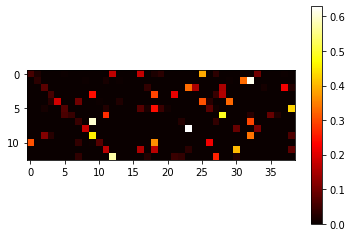

################### loop done #######################
loop 1


/tmp/ipykernel_5736/4063478249.py:78: UserWarning: Attempting to set identical bottom == top == 536.6534937400601 results in singular transformations; automatically expanding.
  axs.set_ylim([losses_train[-1], (max(np.array(lossByCFunc)[:,1])-min(np.array(lossByCFunc)[:,1]))*1.1+min(np.array(lossByCFunc)[:,1])])
/tmp/ipykernel_5736/4063478249.py:79: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs.set_xlim([min(np.array(lossByCFunc)[:,0])*1.1, max(np.array(lossByCFunc)[:,0])*1.1])


cMax
test @ cCap: 0.5...
updated template set


100%|██████████| 13/13 [00:08<00:00,  1.57it/s]
256it [00:00, 6501.62it/s]
100%|██████████| 198/198 [00:03<00:00, 56.47it/s]


################ EAZY DONE ###################
first c test done
IMPROVEMENT FOUND!!!
$\Delta$ loss: -3.5856367643640397


/tmp/ipykernel_5736/4063478249.py:78: UserWarning: Attempting to set identical bottom == top == 533.067856975696 results in singular transformations; automatically expanding.
  axs.set_ylim([losses_train[-1], (max(np.array(lossByCFunc)[:,1])-min(np.array(lossByCFunc)[:,1]))*1.1+min(np.array(lossByCFunc)[:,1])])
/tmp/ipykernel_5736/4063478249.py:79: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs.set_xlim([min(np.array(lossByCFunc)[:,0])*1.1, max(np.array(lossByCFunc)[:,0])*1.1])


cMax
test @ cCap: 0.5...
updated template set


100%|██████████| 13/13 [00:08<00:00,  1.60it/s]
256it [00:00, 6307.45it/s]
100%|██████████| 198/198 [00:03<00:00, 58.05it/s]


################ EAZY DONE ###################
first c test done
cMax/2
test @ -cCap: 0.25...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.63it/s]
256it [00:00, 7630.02it/s]
100%|██████████| 198/198 [00:03<00:00, 55.65it/s]


################ EAZY DONE ###################
test at -cCap done
################### loop 0 #######################
poly: [-28.66151591  21.65056087 533.06785698]
537.1564996323638
trying c: 0.04040404040404041
updated template set


100%|██████████| 13/13 [00:08<00:00,  1.59it/s]
256it [00:00, 6433.64it/s]
100%|██████████| 198/198 [00:03<00:00, 55.30it/s]


################ EAZY DONE ###################
loss: 536.6073113157356, c: 0.04040404040404041
################### loop 1 #######################
poly: [-27.26410161  18.25641869 534.30666803]
537.3628555023918
trying c: 0.05555555555555556
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.63it/s]
256it [00:00, 6380.53it/s]
100%|██████████| 198/198 [00:03<00:00, 52.44it/s]


################ EAZY DONE ###################
loss: 536.5600110869606, c: 0.05555555555555556
################### loop 2 #######################
poly: [ 559.98957201 -447.70016057   90.98101435  533.16465866]
533.7614341862993
trying c: 0.020202020202020204
updated template set


100%|██████████| 13/13 [00:08<00:00,  1.58it/s]
256it [00:00, 8016.71it/s]
100%|██████████| 198/198 [00:03<00:00, 57.91it/s]


################ EAZY DONE ###################
loss: 536.6131401639695, c: 0.020202020202020204


/tmp/ipykernel_5736/4063478249.py:78: UserWarning: Attempting to set identical bottom == top == 533.067856975696 results in singular transformations; automatically expanding.
  axs.set_ylim([losses_train[-1], (max(np.array(lossByCFunc)[:,1])-min(np.array(lossByCFunc)[:,1]))*1.1+min(np.array(lossByCFunc)[:,1])])
/tmp/ipykernel_5736/4063478249.py:79: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs.set_xlim([min(np.array(lossByCFunc)[:,0])*1.1, max(np.array(lossByCFunc)[:,0])*1.1])


cMax
test @ cCap: 0.4430204534644046...
updated template set


100%|██████████| 13/13 [00:08<00:00,  1.61it/s]
256it [00:00, 6297.42it/s]
100%|██████████| 198/198 [00:03<00:00, 55.19it/s]


################ EAZY DONE ###################
first c test done
cMin
test @ -cCap: -0.05697954653559537...
updated template set


100%|██████████| 13/13 [00:08<00:00,  1.59it/s]
256it [00:00, 7488.52it/s]
100%|██████████| 198/198 [00:03<00:00, 55.57it/s]


################ EAZY DONE ###################
test at -cCap done
################### loop 0 #######################
poly: [143.41452349 -54.73742551 533.06785698]
527.844910095872
trying c: 0.19083640966735418
updated template set


100%|██████████| 13/13 [00:08<00:00,  1.61it/s]
256it [00:00, 7452.40it/s]
100%|██████████| 198/198 [00:03<00:00, 50.11it/s]


################ EAZY DONE ###################
loss: 536.8157873292812, c: 0.19083640966735418
################### loop 1 #######################
poly: [  3.50270817   2.6784434  535.2825282 ]
534.7704916048382
trying c: 0.04040404040404041
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.66it/s]
256it [00:00, 7784.35it/s]
100%|██████████| 198/198 [00:03<00:00, 58.17it/s]


################ EAZY DONE ###################
loss: 536.6584606205921, c: 0.04040404040404041
################### loop 2 #######################
poly: [-267.6880219   145.98315092   -7.96351326  535.09990142]
534.9851424397398
trying c: 0.13636363636363638
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.66it/s]
256it [00:00, 7229.27it/s]
100%|██████████| 198/198 [00:03<00:00, 50.90it/s]


################ EAZY DONE ###################
loss: 536.6952234002952, c: 0.13636363636363638


/tmp/ipykernel_5736/4063478249.py:78: UserWarning: Attempting to set identical bottom == top == 533.067856975696 results in singular transformations; automatically expanding.
  axs.set_ylim([losses_train[-1], (max(np.array(lossByCFunc)[:,1])-min(np.array(lossByCFunc)[:,1]))*1.1+min(np.array(lossByCFunc)[:,1])])
/tmp/ipykernel_5736/4063478249.py:79: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs.set_xlim([min(np.array(lossByCFunc)[:,0])*1.1, max(np.array(lossByCFunc)[:,0])*1.1])


cMax
test @ cCap: 0.5...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
256it [00:00, 6082.73it/s]
100%|██████████| 198/198 [00:03<00:00, 49.91it/s]


################ EAZY DONE ###################
first c test done
cMax/2
test @ -cCap: 0.25...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.66it/s]
256it [00:00, 7537.09it/s]
100%|██████████| 198/198 [00:03<00:00, 54.71it/s]


################ EAZY DONE ###################
test at -cCap done
################### loop 0 #######################
poly: [-1002.1759285    804.13651259   533.06785698]
694.3757452645832
trying c: 0.18181818181818182
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
256it [00:00, 6646.75it/s]
100%|██████████| 198/198 [00:03<00:00, 53.83it/s]


################ EAZY DONE ###################
loss: 671.4933646702096, c: 0.18181818181818182
################### loop 1 #######################
poly: [-1192.14933192   891.83353719   535.38729969]
702.1799649993336
trying c: 0.05555555555555556
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
256it [00:00, 6170.93it/s]
100%|██████████| 198/198 [00:03<00:00, 49.66it/s]


################ EAZY DONE ###################
loss: 559.208551785197, c: 0.05555555555555556
################### loop 2 #######################
poly: [ -129.14748195 -1130.78008692   913.4322918    526.22571801]
-17825.12324929195
trying c: 0.010101010101010102
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.67it/s]
256it [00:00, 5983.45it/s]
100%|██████████| 198/198 [00:03<00:00, 51.81it/s]


################ EAZY DONE ###################
loss: 536.6551754405745, c: 0.010101010101010102


/tmp/ipykernel_5736/4063478249.py:78: UserWarning: Attempting to set identical bottom == top == 533.067856975696 results in singular transformations; automatically expanding.
  axs.set_ylim([losses_train[-1], (max(np.array(lossByCFunc)[:,1])-min(np.array(lossByCFunc)[:,1]))*1.1+min(np.array(lossByCFunc)[:,1])])
/tmp/ipykernel_5736/4063478249.py:79: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs.set_xlim([min(np.array(lossByCFunc)[:,0])*1.1, max(np.array(lossByCFunc)[:,0])*1.1])


cMax
test @ cCap: 0.5...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.66it/s]
256it [00:00, 6241.56it/s]
100%|██████████| 198/198 [00:03<00:00, 52.91it/s]


################ EAZY DONE ###################
first c test done
cMax/2
test @ -cCap: 0.25...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.67it/s]
256it [00:00, 5816.02it/s]
100%|██████████| 198/198 [00:03<00:00, 53.38it/s]


################ EAZY DONE ###################
test at -cCap done
################### loop 0 #######################
poly: [-1212.49004547   909.20021812   533.06785698]
703.511531899044
trying c: 0.030303030303030304
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.67it/s]
256it [00:00, 8524.40it/s]
100%|██████████| 198/198 [00:03<00:00, 54.06it/s]


################ EAZY DONE ###################
loss: 559.1854733799502, c: 0.030303030303030304
################### loop 1 #######################
poly: [-1212.95791116   909.75860565   532.91546159]
703.5027327883179
trying c: 0.005050505050505051
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.63it/s]
256it [00:00, 6591.90it/s]
100%|██████████| 198/198 [00:03<00:00, 58.69it/s]


################ EAZY DONE ###################
loss: 536.6551737573216, c: 0.005050505050505051
################### loop 2 #######################
poly: [  -21.5015904  -1199.88758663   909.14427157   532.63262782]
-587036.7268041945
trying c: 0.14141414141414144
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.67it/s]
256it [00:00, 7749.57it/s]
100%|██████████| 198/198 [00:04<00:00, 48.18it/s]


################ EAZY DONE ###################
loss: 684.5786206629814, c: 0.14141414141414144


/tmp/ipykernel_5736/4063478249.py:78: UserWarning: Attempting to set identical bottom == top == 533.067856975696 results in singular transformations; automatically expanding.
  axs.set_ylim([losses_train[-1], (max(np.array(lossByCFunc)[:,1])-min(np.array(lossByCFunc)[:,1]))*1.1+min(np.array(lossByCFunc)[:,1])])
/tmp/ipykernel_5736/4063478249.py:79: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs.set_xlim([min(np.array(lossByCFunc)[:,0])*1.1, max(np.array(lossByCFunc)[:,0])*1.1])


cMax
test @ cCap: 0.5...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.66it/s]
256it [00:00, 6209.97it/s]
100%|██████████| 198/198 [00:03<00:00, 49.92it/s]


################ EAZY DONE ###################
first c test done
cMax/2
test @ -cCap: 0.25...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
256it [00:00, 9135.97it/s]
100%|██████████| 198/198 [00:03<00:00, 63.79it/s]


################ EAZY DONE ###################
test at -cCap done
################### loop 0 #######################
poly: [-28.5827423   21.48790788 533.06785698]
537.1063969125078
trying c: 0.08080808080808081
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.78it/s]
256it [00:00, 9639.74it/s]
100%|██████████| 198/198 [00:03<00:00, 65.10it/s]


################ EAZY DONE ###################
loss: 536.6535089254669, c: 0.08080808080808081
################### loop 1 #######################
poly: [-34.84644231  22.92672112 533.77756431]
537.5486418296812
trying c: 0.08080808080808081
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.82it/s]
256it [00:00, 8148.48it/s]
100%|██████████| 198/198 [00:02<00:00, 75.03it/s]


################ EAZY DONE ###################
loss: 536.6535089254669, c: 0.08080808080808081
################### loop 2 #######################
poly: [ 355.22943272 -295.00481683   65.89158697  533.06785698]
534.9581020518392
trying c: 0.33333333333333337
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.79it/s]
256it [00:00, 8656.63it/s]
100%|██████████| 198/198 [00:02<00:00, 69.14it/s]


################ EAZY DONE ###################
loss: 536.656631767644, c: 0.33333333333333337


/tmp/ipykernel_5736/4063478249.py:78: UserWarning: Attempting to set identical bottom == top == 533.067856975696 results in singular transformations; automatically expanding.
  axs.set_ylim([losses_train[-1], (max(np.array(lossByCFunc)[:,1])-min(np.array(lossByCFunc)[:,1]))*1.1+min(np.array(lossByCFunc)[:,1])])
/tmp/ipykernel_5736/4063478249.py:79: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs.set_xlim([min(np.array(lossByCFunc)[:,0])*1.1, max(np.array(lossByCFunc)[:,0])*1.1])


cMax
test @ cCap: 0.5...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.78it/s]
256it [00:00, 7166.83it/s]
100%|██████████| 198/198 [00:03<00:00, 64.34it/s]


################ EAZY DONE ###################
first c test done
cMax/2
test @ -cCap: 0.25...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.78it/s]
256it [00:00, 9186.47it/s]
100%|██████████| 198/198 [00:03<00:00, 65.46it/s]


################ EAZY DONE ###################
test at -cCap done
################### loop 0 #######################
poly: [-32.82264871  24.54130364 533.06785698]
537.6552044940032
trying c: 0.19191919191919193
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.76it/s]
256it [00:00, 9119.45it/s]
100%|██████████| 198/198 [00:02<00:00, 71.85it/s]


################ EAZY DONE ###################
loss: 535.7967328495694, c: 0.19191919191919193
################### loop 1 #######################
poly: [-26.91976081  21.77638308 533.0103927 ]
537.4143216887143
trying c: 0.015151515151515152
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.80it/s]
256it [00:00, 8257.20it/s]
100%|██████████| 198/198 [00:02<00:00, 66.42it/s]


################ EAZY DONE ###################
loss: 536.6562960208587, c: 0.015151515151515152
################### loop 2 #######################
poly: [ 139.54051749 -115.70358264   28.24564483  534.52165661]
536.2008430915956
trying c: 0.26262626262626265
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.80it/s]
256it [00:00, 9045.54it/s]
100%|██████████| 198/198 [00:03<00:00, 64.64it/s]


################ EAZY DONE ###################
loss: 537.153303087099, c: 0.26262626262626265


/tmp/ipykernel_5736/4063478249.py:78: UserWarning: Attempting to set identical bottom == top == 533.067856975696 results in singular transformations; automatically expanding.
  axs.set_ylim([losses_train[-1], (max(np.array(lossByCFunc)[:,1])-min(np.array(lossByCFunc)[:,1]))*1.1+min(np.array(lossByCFunc)[:,1])])
/tmp/ipykernel_5736/4063478249.py:79: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs.set_xlim([min(np.array(lossByCFunc)[:,0])*1.1, max(np.array(lossByCFunc)[:,0])*1.1])


cMax
test @ cCap: 0.5...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.78it/s]
256it [00:00, 9543.01it/s]
100%|██████████| 198/198 [00:02<00:00, 69.45it/s]


################ EAZY DONE ###################
first c test done
cMax/2
test @ -cCap: 0.25...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.80it/s]
256it [00:00, 8099.07it/s]
100%|██████████| 198/198 [00:02<00:00, 66.22it/s]


################ EAZY DONE ###################
test at -cCap done
################### loop 0 #######################
poly: [-28.51050622  21.4078088  533.06785698]
537.0865007886892
trying c: 0.14141414141414144
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.79it/s]
256it [00:00, 8336.50it/s]
100%|██████████| 198/198 [00:02<00:00, 68.14it/s]


################ EAZY DONE ###################
loss: 536.6445991893324, c: 0.14141414141414144
################### loop 1 #######################
poly: [-35.76509276  24.48578199 533.26483539]
537.4557480456691
trying c: 0.05555555555555556
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.81it/s]
256it [00:00, 7451.57it/s]
100%|██████████| 198/198 [00:03<00:00, 63.22it/s]


################ EAZY DONE ###################
loss: 536.6522866466677, c: 0.05555555555555556
################### loop 2 #######################
poly: [ 337.45755044 -275.29163086   59.84280279  533.37877425]
534.8615678660238
trying c: 0.030303030303030304
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.81it/s]
256it [00:00, 7001.90it/s]
100%|██████████| 198/198 [00:03<00:00, 63.62it/s]


################ EAZY DONE ###################
loss: 536.654706015455, c: 0.030303030303030304


/tmp/ipykernel_5736/4063478249.py:78: UserWarning: Attempting to set identical bottom == top == 533.067856975696 results in singular transformations; automatically expanding.
  axs.set_ylim([losses_train[-1], (max(np.array(lossByCFunc)[:,1])-min(np.array(lossByCFunc)[:,1]))*1.1+min(np.array(lossByCFunc)[:,1])])
/tmp/ipykernel_5736/4063478249.py:79: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs.set_xlim([min(np.array(lossByCFunc)[:,0])*1.1, max(np.array(lossByCFunc)[:,0])*1.1])


cMax
test @ cCap: 0.5...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.80it/s]
256it [00:00, 8660.26it/s]
100%|██████████| 198/198 [00:02<00:00, 69.87it/s]


################ EAZY DONE ###################
first c test done
cMax/2
test @ -cCap: 0.25...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.83it/s]
256it [00:00, 7335.60it/s]
100%|██████████| 198/198 [00:03<00:00, 64.68it/s]


################ EAZY DONE ###################
test at -cCap done
################### loop 0 #######################
poly: [-28.33014121  21.50484306 533.06785698]
537.1488309448188
trying c: 0.010101010101010102
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.79it/s]
256it [00:00, 8607.01it/s]
100%|██████████| 198/198 [00:03<00:00, 64.35it/s]


################ EAZY DONE ###################
loss: 536.6495701878678, c: 0.010101010101010102
################### loop 1 #######################
poly: [-17.46592699  12.65449915 534.74244774]
537.0345726935861
trying c: 0.10101010101010102
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.81it/s]
256it [00:00, 7168.79it/s]
100%|██████████| 198/198 [00:03<00:00, 61.18it/s]


################ EAZY DONE ###################
loss: 536.6663596849826, c: 0.10101010101010102
################### loop 2 #######################
poly: [ 236.02102387 -192.28881616   41.57806384  534.52589815]
535.4932563825315
trying c: 0.3585858585858586
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.79it/s]
256it [00:00, 8393.07it/s]
100%|██████████| 198/198 [00:03<00:00, 63.62it/s]


################ EAZY DONE ###################
loss: 536.7261050223701, c: 0.3585858585858586


/tmp/ipykernel_5736/4063478249.py:78: UserWarning: Attempting to set identical bottom == top == 533.067856975696 results in singular transformations; automatically expanding.
  axs.set_ylim([losses_train[-1], (max(np.array(lossByCFunc)[:,1])-min(np.array(lossByCFunc)[:,1]))*1.1+min(np.array(lossByCFunc)[:,1])])
/tmp/ipykernel_5736/4063478249.py:79: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs.set_xlim([min(np.array(lossByCFunc)[:,0])*1.1, max(np.array(lossByCFunc)[:,0])*1.1])


cMax
test @ cCap: 0.5...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.82it/s]
256it [00:00, 8053.87it/s]
100%|██████████| 198/198 [00:03<00:00, 63.72it/s]


################ EAZY DONE ###################
first c test done
cMax/2
test @ -cCap: 0.25...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.80it/s]
256it [00:00, 9283.53it/s]
100%|██████████| 198/198 [00:03<00:00, 64.57it/s]


################ EAZY DONE ###################
test at -cCap done
################### loop 0 #######################
poly: [-32.99746358  24.75419154 533.06785698]
537.7104107698772
trying c: 0.05555555555555556
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.81it/s]
256it [00:00, 8726.77it/s]
100%|██████████| 198/198 [00:02<00:00, 68.07it/s]


################ EAZY DONE ###################
loss: 538.116062577067, c: 0.05555555555555556
################### loop 1 #######################
poly: [-36.404262    22.88045242 534.65769624]
538.2528460482497
trying c: 0.16161616161616163
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.81it/s]
256it [00:00, 8359.81it/s]
100%|██████████| 198/198 [00:02<00:00, 67.13it/s]


################ EAZY DONE ###################
loss: 537.1840972892289, c: 0.16161616161616163
################### loop 2 #######################
poly: [ 514.74387722 -405.79896866   81.47953311  533.59398865]
534.1830404459573
trying c: 0.4040404040404041
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.81it/s]
256it [00:00, 8193.63it/s]
100%|██████████| 198/198 [00:02<00:00, 73.27it/s]


################ EAZY DONE ###################
loss: 537.1952180876433, c: 0.4040404040404041


/tmp/ipykernel_5736/4063478249.py:78: UserWarning: Attempting to set identical bottom == top == 533.067856975696 results in singular transformations; automatically expanding.
  axs.set_ylim([losses_train[-1], (max(np.array(lossByCFunc)[:,1])-min(np.array(lossByCFunc)[:,1]))*1.1+min(np.array(lossByCFunc)[:,1])])
/tmp/ipykernel_5736/4063478249.py:79: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs.set_xlim([min(np.array(lossByCFunc)[:,0])*1.1, max(np.array(lossByCFunc)[:,0])*1.1])


cMax
test @ cCap: 0.5...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.78it/s]
256it [00:00, 7165.40it/s]
100%|██████████| 198/198 [00:02<00:00, 68.04it/s]


################ EAZY DONE ###################
first c test done
cMax/2
test @ -cCap: 0.25...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.81it/s]
256it [00:00, 8481.57it/s]
100%|██████████| 198/198 [00:03<00:00, 63.16it/s]


################ EAZY DONE ###################
test at -cCap done
################### loop 0 #######################
poly: [-28.63096906  21.46865225 533.06785698]
537.0923717285275
trying c: 0.14141414141414144
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.77it/s]
256it [00:00, 8974.10it/s]
100%|██████████| 198/198 [00:03<00:00, 64.00it/s]


################ EAZY DONE ###################
loss: 536.6456640805327, c: 0.14141414141414144
################### loop 1 #######################
poly: [-35.85231153  24.53252066 533.26393274]
537.4606256713106
trying c: 0.08080808080808081
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.78it/s]
256it [00:00, 9408.06it/s]
100%|██████████| 198/198 [00:03<00:00, 64.63it/s]


################ EAZY DONE ###################
loss: 536.651057434798, c: 0.08080808080808081
################### loop 2 #######################
poly: [ 288.68159583 -242.42576364   56.01959408  533.16312796]
535.2574530072519
trying c: 0.22222222222222224
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.78it/s]
256it [00:00, 8316.49it/s]
100%|██████████| 198/198 [00:02<00:00, 66.28it/s]


################ EAZY DONE ###################
loss: 536.6429100220864, c: 0.22222222222222224


/tmp/ipykernel_5736/4063478249.py:78: UserWarning: Attempting to set identical bottom == top == 533.067856975696 results in singular transformations; automatically expanding.
  axs.set_ylim([losses_train[-1], (max(np.array(lossByCFunc)[:,1])-min(np.array(lossByCFunc)[:,1]))*1.1+min(np.array(lossByCFunc)[:,1])])
/tmp/ipykernel_5736/4063478249.py:79: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs.set_xlim([min(np.array(lossByCFunc)[:,0])*1.1, max(np.array(lossByCFunc)[:,0])*1.1])


cMax
test @ cCap: 0.5...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.77it/s]
256it [00:00, 9037.55it/s]
100%|██████████| 198/198 [00:03<00:00, 65.07it/s]


################ EAZY DONE ###################
first c test done
IMPROVEMENT FOUND!!!
$\Delta$ loss: -14.996379708459813


/tmp/ipykernel_5736/4063478249.py:78: UserWarning: Attempting to set identical bottom == top == 518.0714772672362 results in singular transformations; automatically expanding.
  axs.set_ylim([losses_train[-1], (max(np.array(lossByCFunc)[:,1])-min(np.array(lossByCFunc)[:,1]))*1.1+min(np.array(lossByCFunc)[:,1])])
/tmp/ipykernel_5736/4063478249.py:79: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs.set_xlim([min(np.array(lossByCFunc)[:,0])*1.1, max(np.array(lossByCFunc)[:,0])*1.1])


cMax
test @ cCap: 0.5...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.79it/s]
256it [00:00, 8830.19it/s]
100%|██████████| 198/198 [00:03<00:00, 64.84it/s]


################ EAZY DONE ###################
first c test done
cMax/2
test @ -cCap: 0.25...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.81it/s]
256it [00:00, 9359.02it/s]
100%|██████████| 198/198 [00:02<00:00, 67.31it/s]


################ EAZY DONE ###################
test at -cCap done
################### loop 0 #######################
poly: [-148.40129087  111.25067885  518.07147727]
538.9215545675613
trying c: 0.04040404040404041
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.82it/s]
256it [00:00, 8185.88it/s]
100%|██████████| 198/198 [00:02<00:00, 69.04it/s]


################ EAZY DONE ###################
loss: 536.61205540064, c: 0.04040404040404041
################### loop 1 #######################
poly: [-141.03774332   93.36555525  524.59927946]
540.0510420543246
trying c: 0.0
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.77it/s]
256it [00:00, 8067.61it/s]
100%|██████████| 198/198 [00:02<00:00, 71.38it/s]


################ EAZY DONE ###################
loss: 536.6534927036653, c: 0.0
################### loop 2 #######################
poly: [ 1831.3722508  -1447.60241722   284.42616389   527.36248499]
526.7145706238839
trying c: 0.0
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.79it/s]
256it [00:00, 8514.46it/s]
100%|██████████| 198/198 [00:02<00:00, 66.27it/s]


################ EAZY DONE ###################
loss: 536.6534927036653, c: 0.0


/tmp/ipykernel_5736/4063478249.py:78: UserWarning: Attempting to set identical bottom == top == 518.0714772672362 results in singular transformations; automatically expanding.
  axs.set_ylim([losses_train[-1], (max(np.array(lossByCFunc)[:,1])-min(np.array(lossByCFunc)[:,1]))*1.1+min(np.array(lossByCFunc)[:,1])])
/tmp/ipykernel_5736/4063478249.py:79: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs.set_xlim([min(np.array(lossByCFunc)[:,0])*1.1, max(np.array(lossByCFunc)[:,0])*1.1])


cMax
test @ cCap: 0.4987388603243782...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.80it/s]
256it [00:00, 7788.98it/s]
100%|██████████| 198/198 [00:03<00:00, 65.46it/s]


################ EAZY DONE ###################
first c test done
IMPROVEMENT FOUND!!!
$\Delta$ loss: -4.688391127074965


/tmp/ipykernel_5736/4063478249.py:78: UserWarning: Attempting to set identical bottom == top == 513.3830861401613 results in singular transformations; automatically expanding.
  axs.set_ylim([losses_train[-1], (max(np.array(lossByCFunc)[:,1])-min(np.array(lossByCFunc)[:,1]))*1.1+min(np.array(lossByCFunc)[:,1])])
/tmp/ipykernel_5736/4063478249.py:79: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs.set_xlim([min(np.array(lossByCFunc)[:,0])*1.1, max(np.array(lossByCFunc)[:,0])*1.1])


cMax
test @ cCap: 0.5...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.78it/s]
256it [00:00, 8669.21it/s]
100%|██████████| 198/198 [00:02<00:00, 67.27it/s]


################ EAZY DONE ###################
first c test done
cMax/2
test @ -cCap: 0.25...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.82it/s]
256it [00:00, 7386.52it/s]
100%|██████████| 198/198 [00:02<00:00, 66.47it/s]


################ EAZY DONE ###################
test at -cCap done
################### loop 0 #######################
poly: [-187.78574754  141.10088468  513.38308614]
539.8886382367965
trying c: 0.015151515151515152
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.85it/s]
256it [00:00, 8547.33it/s]
100%|██████████| 198/198 [00:03<00:00, 66.00it/s]


################ EAZY DONE ###################
loss: 536.655253505166, c: 0.015151515151515152
################### loop 1 #######################
poly: [-128.32025736   89.79608411  523.84226456]
539.5516640048257
trying c: 0.08080808080808081
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.81it/s]
256it [00:00, 7128.48it/s]
100%|██████████| 198/198 [00:03<00:00, 62.48it/s]


################ EAZY DONE ###################
loss: 536.669346039642, c: 0.08080808080808081
################### loop 2 #######################
poly: [ 2115.80399317 -1704.40813232   355.00707072   521.1569205 ]
525.8507800235276
trying c: 0.0
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.79it/s]
256it [00:00, 9158.88it/s]
100%|██████████| 198/198 [00:02<00:00, 66.32it/s]


################ EAZY DONE ###################
loss: 536.6534927036653, c: 0.0


/tmp/ipykernel_5736/4063478249.py:78: UserWarning: Attempting to set identical bottom == top == 513.3830861401613 results in singular transformations; automatically expanding.
  axs.set_ylim([losses_train[-1], (max(np.array(lossByCFunc)[:,1])-min(np.array(lossByCFunc)[:,1]))*1.1+min(np.array(lossByCFunc)[:,1])])
/tmp/ipykernel_5736/4063478249.py:79: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs.set_xlim([min(np.array(lossByCFunc)[:,0])*1.1, max(np.array(lossByCFunc)[:,0])*1.1])


cMax
test @ cCap: 0.5...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.81it/s]
256it [00:00, 9422.67it/s]
100%|██████████| 198/198 [00:02<00:00, 66.79it/s]


################ EAZY DONE ###################
first c test done
IMPROVEMENT FOUND!!!
$\Delta$ loss: -0.21387944218668054


/tmp/ipykernel_5736/4063478249.py:78: UserWarning: Attempting to set identical bottom == top == 513.1692066979746 results in singular transformations; automatically expanding.
  axs.set_ylim([losses_train[-1], (max(np.array(lossByCFunc)[:,1])-min(np.array(lossByCFunc)[:,1]))*1.1+min(np.array(lossByCFunc)[:,1])])
/tmp/ipykernel_5736/4063478249.py:79: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs.set_xlim([min(np.array(lossByCFunc)[:,0])*1.1, max(np.array(lossByCFunc)[:,0])*1.1])


cMax
test @ cCap: 0.5...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.79it/s]
256it [00:00, 9196.22it/s]
100%|██████████| 198/198 [00:03<00:00, 65.27it/s]


################ EAZY DONE ###################
first c test done
cMax/2
test @ -cCap: 0.25...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.81it/s]
256it [00:00, 7604.83it/s]
100%|██████████| 198/198 [00:02<00:00, 68.57it/s]


################ EAZY DONE ###################
test at -cCap done
################### loop 0 #######################
poly: [-1422.02741727  1069.71535006   513.1692067 ]
714.3416518043747
trying c: 0.24242424242424243
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.80it/s]
256it [00:00, 7975.21it/s]
100%|██████████| 198/198 [00:02<00:00, 69.26it/s]


################ EAZY DONE ###################
loss: 691.7114474467846, c: 0.24242424242424243
################### loop 1 #######################
poly: [-1444.32535833  1080.77974219   513.19099204]
715.3761929749272
trying c: 0.09595959595959597
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.79it/s]
256it [00:00, 9358.12it/s]
100%|██████████| 198/198 [00:03<00:00, 61.70it/s]


################ EAZY DONE ###################
loss: 671.9973805244128, c: 0.09595959595959597
################### loop 2 #######################
poly: [ 11716.91733512 -10187.91031616   2523.37518447    513.20287266]
642.3694878261091
trying c: 0.47979797979797983
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.79it/s]
256it [00:00, 7510.73it/s]
100%|██████████| 198/198 [00:03<00:00, 64.18it/s]


################ EAZY DONE ###################
loss: 692.5195675077659, c: 0.47979797979797983


/tmp/ipykernel_5736/4063478249.py:78: UserWarning: Attempting to set identical bottom == top == 513.1692066979746 results in singular transformations; automatically expanding.
  axs.set_ylim([losses_train[-1], (max(np.array(lossByCFunc)[:,1])-min(np.array(lossByCFunc)[:,1]))*1.1+min(np.array(lossByCFunc)[:,1])])
/tmp/ipykernel_5736/4063478249.py:79: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs.set_xlim([min(np.array(lossByCFunc)[:,0])*1.1, max(np.array(lossByCFunc)[:,0])*1.1])


cMax
test @ cCap: 0.5...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.77it/s]
256it [00:00, 8133.67it/s]
100%|██████████| 198/198 [00:02<00:00, 66.46it/s]


################ EAZY DONE ###################
first c test done
cMax/2
test @ -cCap: 0.25...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.81it/s]
256it [00:00, 8968.40it/s]
100%|██████████| 198/198 [00:02<00:00, 66.73it/s]


################ EAZY DONE ###################
test at -cCap done
################### loop 0 #######################
poly: [-191.99349667  144.02798791  513.1692067 ]
540.1806181002822
trying c: 0.05555555555555556
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.80it/s]
256it [00:00, 9139.78it/s]
100%|██████████| 198/198 [00:02<00:00, 70.64it/s]


################ EAZY DONE ###################
loss: 538.1404060463107, c: 0.05555555555555556
################### loop 1 #######################
poly: [-207.8435198   135.31047519  520.56588416]
542.588370970263
trying c: 0.015151515151515152
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.81it/s]
256it [00:00, 9311.86it/s]
100%|██████████| 198/198 [00:02<00:00, 69.00it/s]


################ EAZY DONE ###################
loss: 538.0638836263182, c: 0.015151515151515152
################### loop 2 #######################
poly: [ 3464.03863062 -2730.143323     533.25622437   520.11484763]
518.2678908677713
trying c: 0.09595959595959597
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.81it/s]
256it [00:00, 8830.69it/s]
100%|██████████| 198/198 [00:02<00:00, 67.66it/s]


################ EAZY DONE ###################
loss: 538.1422849528554, c: 0.09595959595959597


/tmp/ipykernel_5736/4063478249.py:78: UserWarning: Attempting to set identical bottom == top == 513.1692066979746 results in singular transformations; automatically expanding.
  axs.set_ylim([losses_train[-1], (max(np.array(lossByCFunc)[:,1])-min(np.array(lossByCFunc)[:,1]))*1.1+min(np.array(lossByCFunc)[:,1])])
/tmp/ipykernel_5736/4063478249.py:79: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs.set_xlim([min(np.array(lossByCFunc)[:,0])*1.1, max(np.array(lossByCFunc)[:,0])*1.1])


cMax
test @ cCap: 0.5...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.80it/s]
256it [00:00, 5679.28it/s]
100%|██████████| 198/198 [00:02<00:00, 69.68it/s]


################ EAZY DONE ###################
first c test done
cMax/2
test @ -cCap: 0.25...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.79it/s]
256it [00:00, 9025.01it/s]
100%|██████████| 198/198 [00:03<00:00, 60.83it/s]


################ EAZY DONE ###################
test at -cCap done
################### loop 0 #######################
poly: [-1374.84777661  1031.33179388   513.1692067 ]
706.5806678013114
trying c: 0.4747474747474748
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.81it/s]
256it [00:00, 7685.50it/s]
100%|██████████| 198/198 [00:02<00:00, 69.97it/s]


################ EAZY DONE ###################
loss: 685.1193889717808, c: 0.4747474747474748
################### loop 1 #######################
poly: [-1389.83962469  1030.89133404   513.36962043]
704.5314141591001
trying c: 0.4747474747474748
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.80it/s]
256it [00:00, 9557.97it/s]
100%|██████████| 198/198 [00:03<00:00, 54.09it/s]


################ EAZY DONE ###################
loss: 685.1193889717808, c: 0.4747474747474748
################### loop 2 #######################
poly: [ 2895.51875009 -3546.48683918  1393.27163765   513.1692067 ]
685.0116975725784
trying c: 0.43434343434343436
updated template set


100%|██████████| 13/13 [00:08<00:00,  1.59it/s]
256it [00:00, 7429.66it/s]
100%|██████████| 198/198 [00:03<00:00, 57.12it/s]


################ EAZY DONE ###################
loss: 685.1146114168617, c: 0.43434343434343436


/tmp/ipykernel_5736/4063478249.py:78: UserWarning: Attempting to set identical bottom == top == 513.1692066979746 results in singular transformations; automatically expanding.
  axs.set_ylim([losses_train[-1], (max(np.array(lossByCFunc)[:,1])-min(np.array(lossByCFunc)[:,1]))*1.1+min(np.array(lossByCFunc)[:,1])])
/tmp/ipykernel_5736/4063478249.py:79: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs.set_xlim([min(np.array(lossByCFunc)[:,0])*1.1, max(np.array(lossByCFunc)[:,0])*1.1])


cMax
test @ cCap: 0.5...
updated template set


100%|██████████| 13/13 [00:08<00:00,  1.62it/s]
256it [00:00, 7467.85it/s]
100%|██████████| 198/198 [00:03<00:00, 52.35it/s]


################ EAZY DONE ###################
first c test done
cMax/2
test @ -cCap: 0.25...
updated template set


100%|██████████| 13/13 [00:08<00:00,  1.59it/s]
256it [00:00, 7379.97it/s]
100%|██████████| 198/198 [00:03<00:00, 56.25it/s]


################ EAZY DONE ###################
test at -cCap done
################### loop 0 #######################
poly: [-207.65674376  151.83785585  513.1692067 ]
540.9250287013546
trying c: 0.0
updated template set


100%|██████████| 13/13 [00:08<00:00,  1.59it/s]
256it [00:00, 8579.16it/s]
100%|██████████| 198/198 [00:03<00:00, 57.98it/s]


################ EAZY DONE ###################
loss: 536.6534927036653, c: 0.0
################### loop 1 #######################
poly: [-113.71959974   81.38499784  524.9113497 ]
539.4724233597616
trying c: 0.0
updated template set


100%|██████████| 13/13 [00:08<00:00,  1.60it/s]
256it [00:00, 6997.29it/s]
100%|██████████| 198/198 [00:03<00:00, 58.68it/s]


################ EAZY DONE ###################
loss: 536.6534927036653, c: 0.0
################### loop 2 #######################
poly: [-1.09559607e+02 -2.37513210e-01  4.42057610e+01  5.28825397e+02]
517.9854931712257
trying c: 0.0


/home/t/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


updated template set


100%|██████████| 13/13 [00:08<00:00,  1.56it/s]
256it [00:00, 7319.80it/s]
100%|██████████| 198/198 [00:03<00:00, 54.75it/s]


################ EAZY DONE ###################
loss: 536.6534927036653, c: 0.0


/tmp/ipykernel_5736/4063478249.py:78: UserWarning: Attempting to set identical bottom == top == 513.1692066979746 results in singular transformations; automatically expanding.
  axs.set_ylim([losses_train[-1], (max(np.array(lossByCFunc)[:,1])-min(np.array(lossByCFunc)[:,1]))*1.1+min(np.array(lossByCFunc)[:,1])])
/tmp/ipykernel_5736/4063478249.py:79: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs.set_xlim([min(np.array(lossByCFunc)[:,0])*1.1, max(np.array(lossByCFunc)[:,0])*1.1])


cMax
test @ cCap: 0.5...
updated template set


100%|██████████| 13/13 [00:07<00:00,  1.63it/s]
256it [00:00, 7005.83it/s]
100%|██████████| 199/199 [00:07<00:00, 26.45it/s]


################ EAZY DONE ###################
first c test done
IMPROVEMENT FOUND!!!
$\Delta$ loss: -32.843432450248145


/tmp/ipykernel_5736/4063478249.py:78: UserWarning: Attempting to set identical bottom == top == 480.32577424772643 results in singular transformations; automatically expanding.
  axs.set_ylim([losses_train[-1], (max(np.array(lossByCFunc)[:,1])-min(np.array(lossByCFunc)[:,1]))*1.1+min(np.array(lossByCFunc)[:,1])])
/tmp/ipykernel_5736/4063478249.py:79: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs.set_xlim([min(np.array(lossByCFunc)[:,0])*1.1, max(np.array(lossByCFunc)[:,0])*1.1])


cMax
test @ cCap: 0.5...
updated template set


100%|██████████| 13/13 [00:12<00:00,  1.05it/s]
256it [00:00, 6257.24it/s]
100%|██████████| 198/198 [00:04<00:00, 48.11it/s]


################ EAZY DONE ###################
first c test done
cMax/2
test @ -cCap: 0.25...
updated template set


100%|██████████| 13/13 [00:11<00:00,  1.15it/s]
256it [00:00, 5466.64it/s]
100%|██████████| 198/198 [00:03<00:00, 56.52it/s]


################ EAZY DONE ###################
test at -cCap done
################### loop 0 #######################
poly: [-413.94321523  312.78879392  480.32577425]
539.4140899888331
trying c: 0.21212121212121213
updated template set


100%|██████████| 13/13 [00:12<00:00,  1.02it/s]
256it [00:00, 3414.53it/s]
 68%|██████▊   | 134/198 [00:17<00:15,  4.01it/s]

In [55]:
############# MAIN #############
#setup updating plot
"""plt.ion()
figure, axs = plt.subplots(2, 1, figsize=(10,10))
axs[1].set_yscale("log")
axs[1].set_xscale("log")
dummy1 = np.zeros((13, spectras.shape[0]))-3
dummy1[0][0] = 0.1
axisImg1 = axs[0].imshow(dummy1, cmap="hot")
lines = [axs[i].plot([], [])[0] for i in range(1,2)]
cbar1 = figure.colorbar(axisImg1, ax=axs[0])#, values=np.linspace(0,1,100))
figure.canvas.draw()"""
c = 0
polynomium = lambda x, a, b, c: a*x**2 + b*x + c
#put in name for computed matrix
matrixName = input("Optimized matrix name: ")
print("################### START #######################")
def testC(c,N,matrix,spectras):
    matrix = matrix + c*N
    return meassureBadnessOfZ(matrix,spectras)
losses_train = []
losses_test = []
print("initial loss test...")
losses_train.append(testC(0,matrix,matrix,spectras))#initial loss
print("initial loss test done")
#main loop
for i in range(100000):
    print(f"loop {i}")
    betterFound = False
    def found(loss):
        global betterFound
        global losses_train
        print("IMPROVEMENT FOUND!!!")
        print(rf"$\Delta$ loss: {loss-losses_train[-1]}")
        betterFound = True
        losses_train.append(loss)
    pickBuffer = []
    if i == 0: 
        for j in range(templCnt): pickBuffer.append([j,j])
    for nCol,NCnt in enumerate(range(1,spectras.shape[0])):#nesting of c-optimization
        #set N to a matrix with a random index =1
        N = np.zeros((templCnt,spectras.shape[0]),dtype=np.float64)
        j = 0
        p1,p2 = 0,0
        while j < 1 or [p1,p2] in pickBuffer:
            p1 = np.random.randint(0,templCnt)
            #p2 = np.random.randint(0,spectras.shape[0])
            p2 = nCol
            N[p1][p2] = 1
            j += 1
        cMin = (-matrix[p1][p2])*cCap
        cMax = (1-matrix[p1][p2])*cCap
        pickBuffer.append([p1,p2])
        plt.imshow(matrix + c*N, cmap="hot")
        plt.colorbar()
        plt.savefig(f"matrix_{i}.png")
        plt.savefig("matrix_current.png")
        plt.close()
        """for j in range(len(N)):
            for k in range(len(N[j])):
                if N[j][k] > (1-matrix[j][k])/cCap: N[j][k] = (1-matrix[j][k])/cCap
                if N[j][k] < (0-matrix[j][k])/cCap: N[j][k] = (0-matrix[j][k])/cCap"""
        lossByCFunc = [[0,losses_train[-1]]]
        ###setup c plot####
        #plt.ion()
        
        
        
        def updatePlt(lossByCFunc, poly=None):
            figure, axs = plt.subplots(1, 1, figsize=(5,5))
            lines = [
                axs.plot([], [])[0],# polynomialfit
                axs.plot([], [], marker=".", linestyle="")[0]# lossByCFunc
            ]
            axs.set_xlabel("c")
            axs.set_ylabel("loss")
            lines[1].set_data(np.array(lossByCFunc)[:,0], np.array(lossByCFunc)[:,1])
            axs.set_ylim([losses_train[-1], (max(np.array(lossByCFunc)[:,1])-min(np.array(lossByCFunc)[:,1]))*1.1+min(np.array(lossByCFunc)[:,1])])
            axs.set_xlim([min(np.array(lossByCFunc)[:,0])*1.1, max(np.array(lossByCFunc)[:,0])*1.1])
            if poly is not None:
                lines[0].set_data(np.linspace(-cCap,cCap,100), np.polyval(poly, np.linspace(-cCap,cCap,100)))
            #figure.canvas.draw()
            plt.savefig(f"lossByCFunc_{i}_{NCnt}.png")
            plt.savefig("lossByCFunc_current.png")
            plt.close()
        updatePlt(lossByCFunc)
        ####################

        #initially test at pm cCap
        
        if cMax == 0:
            c = cMin/2
            print("cMin/2")
        else:
            c = cMax
            print("cMax")
        print(f"test @ cCap: {c}...")
        loss = testC(c,N,matrix,spectras)
        print("first c test done")
        if loss < losses_train[-1]:
            found(loss)
            cCnt = 1
            #break
            continue
        lossByCFunc.append([c,loss])
        updatePlt(lossByCFunc)
        if cMin == 0:
            c = cMax/2
            print("cMax/2")
        else:
            c = cMin
            print("cMin")
        print(f"test @ -cCap: {c}...")
        loss = testC(c,N,matrix,spectras)
        if loss < losses_train[-1]: 
            cCnt = 2
            found(loss)
            #break
            continue
        lossByCFunc.append([c,loss])
        updatePlt(lossByCFunc)
        print("test at -cCap done")
        np.savetxt(f'{out_path}/{matrixName}_{i}.csv', matrix, delimiter=',')
        #find c's by solving polynomials for ))st likely bottom
        for cCnt in range(3,6):#loop of finding c's
            print(f"################### loop {cCnt-3} #######################")
            np.savetxt(f'{out_path}/{matrixName}_{i}.csv', matrix, delimiter=',')
            order = cCnt - 2
            if order < 3: order = 2
            #do polynomial fit
            #poly = curve_fit(polynomium, np.array(lossByCFunc)[:,0], np.array(lossByCFunc)[:,1], p0=[1,0,1])[0]
            poly = np.polyfit(np.array(lossByCFunc)[:,0], np.array(lossByCFunc)[:,1], deg=order)
            print(f"poly: {poly}")
            #insert dots and polyfit
            updatePlt(lossByCFunc, poly)
            #differentiate
            polyDif = np.polyder(poly)
            #find roots
            roots = np.real(np.roots(polyDif))#!exclude complex roots
            #pick a root at random but weighted by how isolated the root is and how low the loss is at that point
            propabilities = []
            for r in roots:
                closestPoints = np.array(lossByCFunc)[:,0] - r
                closestPoints = np.abs(closestPoints)
                closestPoints = np.sort(closestPoints)[:2]
                propabilities.append(np.sum(abs(closestPoints-r)))
            propabilities = np.array(propabilities)
            propabilities = propabilities / np.sum(propabilities)
            for i in range(len(propabilities)):
                propabilities[i] = propabilities[i]/(np.polyval(poly, roots[i]))
            #remove negative propabilities
            propabilities[propabilities < 0] = 0
            propabilities = propabilities**2
            propabilities = propabilities / np.sum(propabilities)
            c = np.random.choice(roots, p=propabilities)
            c = roots[np.argmin(np.polyval(poly, roots))]
            rootVal = np.polyval(poly, c)
            print(rootVal)
            """if abs(c) >= cCap:
                prob = (np.max(np.polyval(poly, np.linspace(-cCap, cCap, 100)))-np.polyval(poly, np.linspace(-cCap, cCap, 100)))
                c = np.random.choice(np.linspace(-cCap, cCap, 100), 1, p=prob/np.sum(prob))"""
            if c < 0 or c > cCap or rootVal > losses_train[-1]:#i <= 5 and c < 0: 
                prob = (np.max(np.polyval(poly, np.linspace(0, cCap, 100)))-np.polyval(poly, np.linspace(0, cCap, 100)))
                c = np.random.choice(np.linspace(0, cCap, 100), 1, p=prob/np.sum(prob))[0]
            print(f"trying c: {c}")
            loss = testC(c,N,matrix,spectras)
            lossByCFunc.append([c,loss])
            if loss < losses_train[-1]: 
                found(loss)
                break
            plt.close()
            plt.imshow(matrix + c*N, cmap="hot")
            plt.colorbar()
            plt.savefig(f"matrix_{i}.png")
            plt.savefig("matrix_current.png")
            plt.close()
            plt.imshow(N, cmap="hot")
            plt.colorbar()
            plt.savefig(f"N_{i}.png")
            print(f"loss: {loss}, c: {c}")
        updatePlt(lossByCFunc,poly)
        np.savetxt(f'{out_path}/{matrixName}_{i}.csv', matrix, delimiter=',')
        """if betterFound: 
            break"""
    if not betterFound: cCap = cCap*0.5
    if betterFound: losses_train.append(loss)
    plt.close()
    np.savetxt(f'{out_path}/{matrixName}_{i}.csv', matrix, delimiter=',')
    matrix = matrix + c*N
    for j in range(len(matrix)):
        for k in range(len(matrix[j])):
            if matrix[j][k] > 1: matrix[j][k] = 1
            if matrix[j][k] < 0: matrix[j][k] = 0
        matrix[j] = matrix[j] / np.sum(matrix[j])
    plt.imshow(matrix, cmap="hot")
    plt.colorbar()
    plt.savefig(f"matrix_{i}.png")
    plt.show()
    np.savetxt(f'{out_path}/{matrixName}_{i}.csv', matrix, delimiter=',')
    if i % 10 == 0:
        losses_test.append(meassureBadnessOfZ(matrix,spectras))
        plt.plot(losses_train, label="train")
        plt.plot(losses_test, label="test")
        plt.legend()
        plt.savefig(f"losses.png")
    print("################### loop done #######################")
    #save plot
    #plt.savefig(f"lossByCFunc_{i}.png")
    plt.close()
    if cCap == 0: break



In [ ]:
"""
        #initialize model
        #model = tf.Variable(np.random.uniform(0,1, size=(13, spectras.shape[0])), dtype=tf.float32)
        model = tf.Variable(np.zeros((13, spectras.shape[0]),dtype=float), dtype=tf.float32)
        for i in tf.range(model.shape[1]):
            model[i%13,i].assign(1)
        losses = []
        for i in range(10000):
            loss = train_step(model, spectras)
            model = fixModel(model)
            if i % 10 == 0:
                print(loss.numpy())
            if i % 1 == 0 and i > 0:
                #do a matplotlib heatmap of matrix
                axisImg1.set_data(np.log(model.numpy()+lSque))
                dummy = performMatrixOperation(model, spectras)
                axisImg2.set_data(np.log(gridOut(dummy).numpy()+lSque))
                axisImg3.set_data(np.reshape(np.log(vecOut(dummy).numpy()), (1,13)))
                #axisImg2.set_data(gridOut(dummy).numpy()+lSque)
                #axisImg3.set_data(np.reshape(vecOut(dummy).numpy(), (1,13)))
                lines[0].set_data(np.arange(len(orthogonalities)), orthogonalities)
                lines[1].set_data(np.arange(len(rowStds)), rowStds)
                lines[2].set_data(np.arange(len(colStds)), colStds)
                axs[3].set_xlim(0, len(orthogonalities))
                axs[4].set_xlim(0, len(rowStds))
                axs[5].set_xlim(0, len(colStds))
                axs[3].set_ylim(np.min(orthogonalities), np.max(orthogonalities))
                axs[4].set_ylim(np.min(rowStds), np.max(rowStds))
                axs[5].set_ylim(np.min(colStds), np.max(colStds))
                figure.canvas.draw()
                figure.canvas.flush_events() 
            if i % 30 == 0:
                np.save(f"templates-custom/45k/optimized_matrix_{matrixName}.npy", model.numpy())
            print(".", end="")
            losses.append(loss.numpy())
            orthogonalities.append(orthogonalityMeassure(performMatrixOperation(model, spectras)))
            rowStds.append(rowwiseStandardDeviationMeassure(model))
            colStds.append(columnwiseStandardDeviationMeassure(model))
            if len(losses) > 1000:
                if abs(loss-losses[-100]) < 0.000005:
                    break
        #save model
        np.save(f"{path}/optimized_matrix_{matrixName}_score:{loss:.3f}_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.npy", model.numpy())
        losseses.append(losses)
    except KeyboardInterrupt:
        print("KeyboardInterrupt")
        np.save(f"{path}/optimized_matrix_{matrixName}_score:{loss:.3f}_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.npy", model.numpy())
        losseses.append(losses)
        

#show losses
import matplotlib.pyplot as plt
[plt.plot(losses) for losses in losseses]
plt.show()"""

'\n        #initialize model\n        #model = tf.Variable(np.random.uniform(0,1, size=(13, spectras.shape[0])), dtype=tf.float32)\n        model = tf.Variable(np.zeros((13, spectras.shape[0]),dtype=float), dtype=tf.float32)\n        for i in tf.range(model.shape[1]):\n            model[i%13,i].assign(1)\n        losses = []\n        model = fixModel(model)\n        for i in range(10000):\n            loss = train_step(model, spectras)\n            model = fixModel(model)\n            if i % 10 == 0:\n                print(loss.numpy())\n            if i % 1 == 0 and i > 0:\n                #do a matplotlib heatmap of matrix\n                axisImg1.set_data(np.log(model.numpy()+lSque))\n                dummy = performMatrixOperation(model, spectras)\n                axisImg2.set_data(np.log(gridOut(dummy).numpy()+lSque))\n                axisImg3.set_data(np.reshape(np.log(vecOut(dummy).numpy()), (1,13)))\n                #axisImg2.set_data(gridOut(dummy).numpy()+lSque)\n            